In [1]:
import os
import re
import itertools
import warnings
from joblib import dump

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

from scipy import stats, signal
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score

warnings.filterwarnings("ignore")
random_state = 42
activities = ["dab", "jamesbond", "mermaid", "pushback", "scarecrow", "snake"]
n_labels = len(activities)

In [2]:
dfs = []

def load_data(activity, label, trials, subject):
    for trial in trials:
        df = pd.read_csv(os.path.join(subject, activity+str(trial)+".csv"), sep=",", index_col=0)
#         df = df[40:-40]
        df["activity"] = [label for _ in range(len(df))]
        df["activityName"] = [activity for _ in range(len(df))]
        df["trial"] = [trial for _ in range(len(df))]
        df["subject"] = [subject for _ in range(len(df))]
        dfs.append(df)

ids = [1, 2, 3, 4, 5, 6, 7]
user = "subject1"
load_data("dab", 0, ids, user)
load_data("jamesbond", 1, ids, user)
load_data("mermaid", 2, ids, user)
# load_data("pushback", 3, ids, user)
# load_data("scarecrow", 4, ids, user)
# load_data("snake", 5, ids, user)
# load_data("elbowkick", 6, ids, user)
# load_data("pointhigh", 7, ids, user)
# load_data("logout", 8, ids, user)

user = "subject2"
load_data("dab", 0, ids, user)
load_data("jamesbond", 1, ids, user)
load_data("mermaid", 2, ids, user)
# load_data("dab", 3, ids, user)
# load_data("wipetable", 4, ids, user)
# load_data("gun", 5, ids, user)
# load_data("elbowkick", 6, ids, user)
# load_data("pointhigh", 7, ids, user)
# load_data("logout", 8, ids, user)

user = "subject3"
load_data("dab", 0, ids, user)
load_data("jamesbond", 1, ids, user)
load_data("mermaid", 2, ids, user)
# load_data("dab", 3, ids, user)
# load_data("wipetable", 4, ids, user)
# load_data("gun", 5, ids, user)
# load_data("elbowkick", 6, ids, user)
# load_data("pointhigh", 7, ids, user)
# load_data("logout", 8, ids, user)

ids = [1, 2, 3, 4, 10]
user = "subject1"
load_data("pushback", 3, ids, user)
load_data("scarecrow", 4, ids, user)
load_data("snake", 5, ids, user)

user = "subject2"
load_data("pushback", 3, ids, user)
load_data("scarecrow", 4, ids, user)
load_data("snake", 5, ids, user)

ids = [1, 2, 3, 4, 5, 6, 7]
user = "subject3"
load_data("pushback", 3, ids, user)
load_data("scarecrow", 4, ids, user)
load_data("snake", 5, ids, user)

# ids = [1, 2]
# user = "subject2"
# load_data("scarecrow", 4, ids, user)


df = pd.concat(dfs)
print(df.shape)
df.head()

(34200, 13)


yaw  pitch   roll     g_x    g_y    g_z   a_x   a_y   a_z  activity  \
0  -0.05  12.99  72.28   -6.47  -2.95  -1.05 -0.20  1.00 -0.17         0   
1  -1.67  15.87  55.53  -67.89  11.78  -6.40 -0.26  1.29 -0.01         0   
2 -18.20   5.15   9.66 -180.85 -41.34 -70.00 -0.25  1.47  1.91         0   
3  23.60   7.15 -49.80 -250.14   7.11  91.12 -0.27  1.37 -0.11         0   
4 -10.80  23.43 -50.88   -4.71  59.81 -41.99 -0.66 -0.72  0.06         0   

  activityName  trial   subject  
0          dab      1  subject1  
1          dab      1  subject1  
2          dab      1  subject1  
3          dab      1  subject1  
4          dab      1  subject1

In [3]:
# def plot_distribution_of_data(df, title=""):
#     activity, counts = np.unique(df.activityName, return_counts=True)
#     index = np.arange(len(activity))
#     plt.figure(figsize=(12, 5))
#     plt.bar(index, counts, align = 'center', alpha=0.5, color='lightblue')
#     plt.suptitle(title, fontsize=16)
#     plt.xticks(index, activity, rotation=90, fontsize=8)
#     plt.xlim([-.5, 8.5])
#     plt.ylabel('frequency', fontsize=10)
#     for i, v in enumerate(counts):
#         plt.text(i, v, str(v), color='grey', fontweight='bold')
#     plt.show()

# plot_distribution_of_data(df, title='Class Distribution Of Dataset')

In [4]:
# def plot_distribution_of_data_per_user(df, title=""):
#     plt.figure(figsize=(16,8))
#     plt.title(title, fontsize=20)
#     sns.countplot(x='subject',hue='activityName', data=df)
#     plt.show()

# plot_distribution_of_data_per_user(df, title='Data Collected Per User')

In [5]:
def convert_to_timeseries(features, num_time_steps, num_features):
    data = np.reshape(features, newshape=(num_time_steps, num_features))
    return data.T

num_time_steps = 30
# 24 also work
X = list()
y = list()
df_len = len(df)
for idx in range(0, df_len, num_time_steps):
# without overlapping window 
#     print(idx)
    window_df = df[idx:idx+num_time_steps]
    labels = window_df["activity"].unique()
    trials = window_df["trial"].unique()
    subjects = window_df["subject"].unique()
    if len(labels) != 1 or len(trials) != 1 or len(subjects) != 1 or len(window_df) < num_time_steps:
        continue
    assert len(labels) == 1 and len(window_df) == num_time_steps
    features = window_df.drop(columns=["activity", "activityName", "subject", "trial"]).values
    features = convert_to_timeseries(features, num_time_steps=num_time_steps, num_features=9)
    X.append(features)
    y.append(labels)
     

X = np.array(X)
y = np.array(y)

X.shape, y.shape
# print(y)

((1140, 9, 30), (1140, 1))

In [6]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cmap='Blues'
        print("Confusion Matrix With Normalization")
    else:
        cmap='Greens'
        print('Confusion Matrix Without Normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()

In [7]:
def compute_mean(data):
    return np.mean(data)

def compute_variance(data):
    return np.var(data)

def compute_median_absolute_deviation(data):
    return stats.median_absolute_deviation(data)

def compute_root_mean_square(data):
    def compose(*fs):
        def wrapped(x):
            for f in fs[::-1]:
                x = f(x)
            return x
        return wrapped
    rms = compose(np.sqrt, np.mean, np.square)
    return rms(data)

def compute_kurtosis(data):
    return stats.kurtosis(data)

def compute_min_max(data):
    return np.max(data) - np.min(data)

def compute_spectral_entropy(data):
    freqs, power_density = signal.welch(data)
    return stats.entropy(power_density)

def compute_spectral_energy(data):
    freqs, power_density = signal.welch(data)
    return np.sum(np.square(power_density))

def compute_principle_frequency(data):
    freqs, power_density = signal.welch(data)
    return freqs[np.argmax(np.square(power_density))]

In [8]:
feature_names = []

# Rotation around the front-to-back axis is called roll.
# Rotation around the side-to-side axis is called pitch.
# Rotation around the vertical axis is called yaw.
# acc can detect the orientation but gyro cannot 
# for i in ["yaw", "pitch", "roll", "gyro_x", "gyro_y", "gyro_z", "acc_x", "acc_y", "acc_z"]:
#         for j in ["_mean", "_var", "_mad", "_rms", "_kurtosis", "_min_max", "_entropy", "_energy", "_pfreq"]:
#             feature_names.append(i+j)
for i in ["yaw", "pitch", "roll", "gyro_x", "gyro_y", "gyro_z", "acc_x", "acc_y", "acc_z"]:
        for j in ["_mean", "_var", "_mad", "_rms", "_kurtosis", "_min_max", "_entropy", "_pfreq"]:
            feature_names.append(i+j)

n_features = len(feature_names)

def rename_raw_data_headers(X, columns):
    X = pd.DataFrame(X)
    X.columns = columns
    return X

def extract_raw_data_features_per_row(f_n):
    f1_mean = compute_mean(f_n)
    f1_var = compute_variance(f_n)
    f1_mad = compute_median_absolute_deviation(f_n)
    f1_rms = compute_root_mean_square(f_n)
    f1_kurtosis = compute_kurtosis(f_n)
    f1_min_max = compute_min_max(f_n)
    f1_entropy = compute_spectral_entropy(f_n)
#     f1_energy = compute_spectral_energy(f_n)
    f1_pfreq = compute_principle_frequency(f_n)
    return f1_mean, f1_var, f1_mad, f1_rms, f1_kurtosis, f1_min_max, f1_entropy, f1_pfreq

def extract_raw_data_features(X):
    new_features = np.ones((X.shape[0], n_features))
    rows = X.shape[0]
    cols = X.shape[1]

    for row in range(rows):
        features = []
        for col in range(cols):
            f_n = X[row][col]
            feature = extract_raw_data_features_per_row(f_n)
            features.extend(feature)
            print(feature)
        new_features[row] = np.array(features)
    print(new_features)

    return new_features


def prepare_raw_data_dataframe(X, y, random_state=42):
    X = extract_raw_data_features(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)
#     X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

#     return X_train, X_valid, X_test, y_train, y_valid, y_test
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_raw_data_dataframe(X, y)
X_train.shape

(-1.6559999999999986, 905.0614506666665, 11.260347000000001, 30.129782386646387, 0.5307831438772688, 130.07, 2.1725676130968585, 0.2)
(24.977666666666664, 1772.616577888889, 40.645478999999995, 48.95406428479662, -0.6155336489816028, 158.92, 1.5406615690937002, 0.06666666666666667)
(13.390666666666666, 1777.572772888889, 36.494198999999995, 44.23666721924999, -0.37583178384174776, 151.15, 1.9183999205376896, 0.13333333333333333)
(-4.635666666666666, 14536.691631222224, 102.803484, 120.65728754064823, -0.27435538419679517, 468.45, 1.752266038273246, 0.13333333333333333)
(4.054, 11196.993897333334, 82.098975, 105.8934786156982, -0.011633672035538556, 412.52, 2.111868170997095, 0.06666666666666667)
(5.689333333333335, 11810.024159555556, 31.364403, 108.82275806711266, 1.1168429790041756, 500.0, 2.114251078208129, 0.06666666666666667)
(-0.38466666666666666, 0.2768382222222222, 0.3706499999999999, 0.6517719437553804, 0.9933964364096299, 2.16, 2.1186683845293874, 0.2)
(0.7856666666666665, 0.

(5.532333333333332, 1822.140937888889, 41.349714, 43.043555266729534, -0.7729348193638432, 139.14, 1.6124826198493374, 0.13333333333333333)
(-3.513333333333338, 15900.418588888888, 127.79270700000001, 126.14579699696696, -0.29068398147134156, 500.27, 1.4919632499439521, 0.13333333333333333)
(-11.38466666666667, 8899.761678222223, 79.815771, 95.02300938895449, -0.04151806142388814, 430.16, 2.444856881831015, 0.13333333333333333)
(17.83466666666667, 9054.00776488889, 33.247305, 96.80951967652769, 1.1430304600638417, 442.1, 2.1060888071259356, 0.2)
(-0.392, 0.21908266666666662, 0.25945500000000005, 0.610529824551321, 0.5836035256283361, 2.13, 2.076851125928524, 0.2)
(0.8099999999999999, 0.6367733333333333, 0.9636900000000002, 1.1370458800476493, -1.1067607997220787, 2.57, 1.8294776145085834, 0.13333333333333333)
(0.4556666666666666, 0.1533312222222222, 0.415128, 0.6008022414516555, -0.3692393495296118, 1.44, 2.2191957387519894, 0.4)
(-1.991666666666667, 804.5128205555555, 16.6644239999999

(21.959000000000003, 6610.671662333332, 26.872125, 84.21917443987049, 1.825315547641753, 371.0, 2.3511721626667264, 0.06666666666666667)
(-0.35800000000000004, 0.352796, 0.43736699999999995, 0.6935127972863947, 0.2122741988878607, 2.65, 2.28997546254302, 0.2)
(0.7580000000000001, 0.6585093333333333, 0.748713, 1.1104383518833152, -1.152674205911367, 2.62, 2.103715683028301, 0.13333333333333333)
(0.38499999999999995, 0.13782499999999998, 0.511497, 0.5348364235913632, -1.1884517471672662, 1.3199999999999998, 2.4690736536224396, 0.3333333333333333)
(-2.965666666666668, 899.4871978888888, 22.883930999999997, 30.137723481820366, 0.4039363768257478, 135.07, 2.292992767322553, 0.06666666666666667)
(37.05166666666667, 1279.156427222222, 32.795111999999996, 51.49740216748802, -0.27832682259589614, 127.67, 1.6205293979444209, 0.06666666666666667)
(0.5186666666666658, 1887.1013182222223, 45.871643999999996, 43.443875671184465, -0.7380585641812893, 154.54000000000002, 1.7747849183440434, 0.13333333

(-2.160666666666664, 11831.317079555556, 56.16830099999999, 108.79331578732216, 0.5289474496819184, 500.27, 1.906702492480349, 0.13333333333333333)
(4.038000000000003, 13245.249022666665, 78.37764899999999, 115.15882279125063, 0.3425810102873541, 500.27, 1.903984228884084, 0.13333333333333333)
(19.649, 6047.0492289999975, 31.520075999999996, 80.2068103716885, 2.5933577620447945, 349.7, 2.2800209048112117, 0.06666666666666667)
(-0.3963333333333333, 0.4051965555555556, 0.47443199999999996, 0.7498510963295758, -0.31122259803076613, 2.56, 2.2069246287084288, 0.13333333333333333)
(0.637, 0.7135476666666667, 1.2453839999999998, 1.0579776305133612, -1.3714112856299396, 2.63, 1.9154112745483949, 0.13333333333333333)
(0.38900000000000007, 0.18025566666666668, 0.511497, 0.5758269415950131, -0.9632788069791651, 1.5899999999999999, 2.1303741595528076, 0.43333333333333335)
(-1.8929999999999998, 1013.5307076666667, 23.588165999999998, 31.892227213957113, 0.06636786251634286, 129.82, 2.28192213529255

(-0.23399999999999999, 0.06843066666666668, 0.289107, 0.35097958155235565, -0.732683902335566, 1.01, 1.6392630179622727, 0.2)
(-0.028000000000000008, 0.027816, 0.185325, 0.1691153452528776, 0.08000526736814839, 0.78, 2.3717999051036887, 0.2)
(-1.8396666666666666, 110.26968322222223, 11.986821, 10.660865662162086, -0.704315439775776, 40.349999999999994, 2.3508643981925648, 0.1)
(55.84200000000001, 240.4467826666667, 14.774108999999994, 57.95494583438644, -0.1591872313940259, 67.78999999999999, 1.950540578758373, 0.1)
(22.724666666666664, 856.9639448888888, 25.137483000000003, 37.059066636924356, -0.3063644187637653, 105.19999999999999, 1.6752915492779512, 0.1)
(-5.528666666666667, 7586.259551555556, 95.234811, 87.27442756424512, -0.9389605284263296, 323.4, 2.0603230454463883, 0.1)
(-1.093666666666669, 2521.430056555555, 52.143042, 50.2257519937067, 0.8174333487728727, 240.92, 2.211702647451821, 0.1)
(-4.621666666666666, 1646.3306138888888, 46.086621, 40.83736544718166, -0.69681092615799

(-4.812333333333333, 7104.680217888888, 116.60649000000001, 84.42652882832505, -1.2298694932654535, 299.6, 2.100734042059952, 0.1)
(-4.706999999999999, 1984.954701, 38.310384, 44.800787381473555, -0.29439231001260113, 177.32, 2.296770335626528, 0.2)
(-5.209333333333335, 1340.1953062222221, 38.154711, 36.97745880938819, -0.43135035467819005, 150.66, 2.3432288386175144, 0.36666666666666664)
(-0.9273333333333333, 0.06893955555555557, 0.26686800000000005, 0.9637876667952681, 0.05708458742181932, 1.1700000000000002, 2.123535770579304, 0.2)
(-0.23566666666666672, 0.0858978888888889, 0.32617199999999996, 0.37608066510612675, -0.39227352956472483, 1.26, 2.067820585268127, 0.2)
(-0.04533333333333333, 0.031104888888888894, 0.200151, 0.1820988742414406, -0.18624891578982972, 0.73, 2.3728869460037427, 0.26666666666666666)
(-0.18933333333333344, 93.43349288888888, 7.198023, 9.667954282059881, 0.09617773391007534, 45.129999999999995, 2.3875737507632575, 0.1)
(66.88333333333334, 142.42494222222226, 1

(-7.7426666666666675, 754.7077128888888, 24.878028, 28.54218982488905, -0.44252467765326786, 102.63, 1.5063625797074227, 0.1)
(-0.751666666666667, 7614.749687222221, 99.03026699999998, 87.26577043721095, -1.1233190062966654, 282.08, 1.9417479850031762, 0.1)
(-2.452, 1021.577516, 19.251561, 32.05604186421025, 1.0695347313467396, 162.32, 2.5272329305727226, 0.2)
(-1.765666666666666, 1188.7380512222223, 45.226713, 34.52326215756559, -1.1874529562203113, 122.39999999999999, 2.3406240844108996, 0.4)
(-0.9616666666666667, 0.044133888888888896, 0.14084700000000003, 0.984345806445411, -0.5141097095160911, 0.7499999999999999, 1.9557486045924737, 0.2)
(-0.08299999999999999, 0.04520100000000002, 0.24462899999999996, 0.228232337761326, -0.43139718618479117, 0.8, 1.8427504224234579, 0.2)
(-0.138, 0.036582666666666666, 0.17049899999999998, 0.23585306160121533, 0.22375199815129054, 0.85, 2.0963219560436697, 0.2)
(-1.02, 72.56218666666668, 9.844463999999999, 8.579194989430341, -1.043604344467397, 29.2

(-0.4903333333333342, 606.1813765555555, 15.767451, 24.625633054468537, 0.4405701260606838, 116.03, 2.4777016276846844, 0.13333333333333333)
(2.310666666666667, 129.61689955555553, 9.992723999999999, 11.617059869002999, 0.2893411677613349, 47.13, 1.8893058829284295, 0.13333333333333333)
(0.11066666666666668, 0.009359555555555555, 0.103782, 0.14699206327780648, -0.45105420309534905, 0.38, 2.429093152139379, 0.13333333333333333)
(0.4326666666666668, 0.1025128888888889, 0.42995400000000006, 0.5382502515868741, -1.3159994028665594, 0.95, 1.123666222535535, 0.13333333333333333)
(0.894, 0.01749733333333333, 0.11860800000000002, 0.9037329989180064, -0.5519650246875187, 0.5599999999999999, 2.068064634988766, 0.13333333333333333)
(0.061333333333333434, 18.42580488888889, 2.260965, 4.292967116886254, 7.361484227650568, 26.740000000000002, 2.4026501638798727, 0.03333333333333333)
(17.508666666666667, 513.0685915555556, 15.396800999999996, 28.629041199453397, -0.7094597774536533, 74.03, 1.39387569

(-0.6993333333333344, 3187.4986195555557, 78.48884399999999, 56.462267813706056, -1.3277086796076238, 184.69, 0.9743100071064619, 0.13333333333333333)
(8.197333333333335, 1049.5395195555554, 25.582262999999998, 33.41759706102959, 1.7250135276808338, 165.01, 2.476782949052592, 0.13333333333333333)
(-2.5283333333333333, 86.3657938888889, 8.710275, 9.631109143464906, 0.45460580650961235, 41.03, 2.3471477704738866, 0.06666666666666667)
(-0.04966666666666667, 0.024896555555555554, 0.133434, 0.16541866077723313, 0.4850095545583355, 0.79, 2.5128008190452737, 0.13333333333333333)
(0.42666666666666664, 0.09375555555555556, 0.363237, 0.5251666402200353, -1.4310033207376134, 0.8700000000000001, 1.1194916510637942, 0.13333333333333333)
(0.9029999999999999, 0.010581000000000005, 0.11119499999999993, 0.9088399198978883, -0.6746490842186175, 0.3900000000000001, 2.226893602188699, 0.4)
(-0.21966666666666665, 4.6597432222222235, 1.497426, 2.169791848695784, -0.12542833337332926, 8.73, 2.53441136526582,

(0.17633333333333348, 111.08963655555557, 9.117989999999999, 10.541381787982067, -0.3561020199600531, 42.8, 2.3359474405198766, 0.13333333333333333)
(-0.014333333333333332, 0.024724555555555562, 0.10378199999999999, 0.15789236840328924, 5.915130698629941, 0.8400000000000001, 2.391546362138773, 0.13333333333333333)
(0.4416666666666667, 0.10272722222222223, 0.31875899999999996, 0.5457074918549925, -1.4017419062135132, 0.95, 1.3817274524163898, 0.13333333333333333)
(0.8946666666666665, 0.012404888888888885, 0.11860799999999994, 0.9015726999711856, 0.3320235964872258, 0.5499999999999999, 2.2377506611850375, 0.26666666666666666)
(0.11766666666666649, 16.83232455555555, 3.5360009999999997, 4.104408605390063, -0.2655202022694083, 17.55, 2.2166356202708632, 0.13333333333333333)
(17.764333333333337, 110.52013788888888, 8.665797, 20.641988195584908, -0.19168964646347098, 38.230000000000004, 1.6830012045070049, 0.03333333333333333)
(21.174000000000003, 381.512284, 25.478481000000002, 28.807126895

(3191.997333333333, 295413236.61162627, 0.31875899999999996, 17481.478300979965, 25.03448273192207, 95750.21, 2.111380837452389, 0.03333333333333333)
(5.398666666666667, 796.8008648888889, 0.9488639999999998, 28.739284379863506, 24.019929826747507, 157.73999999999998, 2.0375705470020606, 0.03333333333333333)
(-3.330333333333334, 392.5692632222222, 0.45219299999999996, 20.091301185670712, 25.004589653959385, 111.03, 2.0893219719554175, 0.03333333333333333)
(5.429333333333334, 895.1078728888891, 19.266387, 30.406998098025614, 0.24904081454400018, 130.0, 2.1154355395974154, 0.23333333333333334)
(-53.56466666666666, 803.0330782222222, 38.75516400000001, 60.598734255208115, -1.107980275399107, 96.21, 1.9351509487403602, 0.16666666666666666)
(-12.898333333333335, 2152.910327222222, 39.815222999999996, 48.1588759212671, -0.24801854897544917, 181.39, 1.8595728961382267, 0.06666666666666667)
(10.816666666666666, 12687.11798888889, 88.274004, 113.15528386543275, 0.21786589903675635, 477.78999999

(-1.5380000000000005, 1539.5046826666664, 20.578487999999997, 39.26665413129398, 2.4950520811224814, 198.28, 2.3222903587039587, 0.16666666666666666)
(-83.76433333333334, 1673.2675178888887, 37.78406099999999, 93.21872696334502, -0.44181280354238384, 142.46, 2.244452492374898, 0.16666666666666666)
(-48.43600000000001, 3051.379217333333, 51.891, 73.4671716709806, -0.3680090655980712, 210.85000000000002, 2.264790989512792, 0.16666666666666666)
(23302.501999999997, 15737328214.84029, 144.316284, 127594.4152943235, 25.0344176688991, 699097.89, 2.6951215212369473, 0.03333333333333333)
(-10.396999999999998, 6616.087187666665, 85.46447699999999, 82.00112680120112, 0.7989706825883753, 384.92999999999995, 2.038090399274452, 0.2)
(5.645000000000004, 11337.517438333334, 87.073098, 106.62731105740843, 0.3244969366785857, 496.9, 2.2148216784493124, 0.16666666666666666)
(-4.562666666666668, 741.320826222222, 0.32617199999999996, 27.606860620746673, 25.022545657253, 152.38, 2.717136304694814, 0.46666

(0.29000000000000004, 0.11034666666666665, 0.504084, 0.4409610716000525, -1.057470498528182, 1.22, 2.4362896593722567, 0.1)
(-1.5496666666666659, 364.34312988888894, 16.16034, 19.150576927776005, 0.8051419020950643, 84.9, 2.465709712141807, 0.4666666666666667)
(-17.42666666666667, 559.0161222222222, 28.769853, 29.371837418406997, -0.8498939551418263, 81.9, 1.5770631761623661, 0.03333333333333333)
(-31.505333333333333, 1220.7390582222222, 43.358637, 47.045989060351005, -0.9975175240966774, 127.24, 1.657574635141448, 0.13333333333333333)
(-1.165999999999997, 7661.622997333335, 81.824694, 87.53846327948266, 0.0755753921184219, 364.11, 2.2022876787473313, 0.16666666666666666)
(0.8539999999999996, 3175.0707506666668, 52.217172, 56.35423734437959, 0.04524088961514927, 246.19, 2.5747056091848712, 0.2)
(-13.211000000000002, 6392.996402333333, 63.292193999999995, 81.04027963508847, -0.12599649067091256, 339.0, 2.5326163223305196, 0.5)
(0.7653333333333333, 0.11037155555555554, 0.378063, 0.834330

(-1.6783333333333326, 347.7068205555555, 16.60512, 18.72227612587031, -0.4215362375821665, 73.7, 2.344532149219725, 0.3)
(-55.51099999999999, 509.47702233333337, 23.699361000000003, 59.924520384675034, 2.309538463289961, 111.76, 2.1601972306818245, 0.03333333333333333)
(-11.281333333333333, 983.7701048888888, 18.147024, 33.33224544891428, -0.6371190828736224, 112.03, 2.2873056133844054, 0.13333333333333333)
(-5.804333333333335, 7993.9424645555555, 62.928957, 89.59705770838684, -0.4294385020088849, 336.65, 1.8397692105973582, 0.13333333333333333)
(8.57, 2174.076833333333, 44.048046, 47.40803448080645, -0.3595762196371721, 193.76999999999998, 2.221776951688795, 0.4666666666666667)
(-13.928333333333335, 3975.465280555555, 50.341682999999996, 64.5713849162305, 0.13129235683489116, 274.43, 2.297009302077563, 0.23333333333333334)
(0.9700000000000001, 1.7583200000000005, 0.23721600000000004, 1.642930308929749, 23.342024268784396, 7.66, 2.0173331247712394, 0.03333333333333333)
(0.066, 0.074337

(5.003666666666666, 591.0053032222222, 12.750360000000002, 24.820193055923905, 10.095667132272075, 138.57, 2.5436489115313448, 0.23333333333333334)
(-99.79833333333333, 1064.3880005555557, 12.616926000000007, 104.99569199098917, 6.405287855428083, 149.17, 2.422669184274034, 0.1)
(-1.8346666666666671, 755.2334648888888, 24.522204, 27.542684449172103, -0.4289413518341907, 101.6, 1.8259012531654608, 0.13333333333333333)
(6.413999999999999, 7004.327897333333, 71.23893, 83.93728190341484, -0.44838423827672447, 295.17999999999995, 1.9845299207644904, 0.13333333333333333)
(0.0643333333333338, 3431.2247712222224, 56.672385, 58.576692549170104, 1.3345586726896208, 304.64, 2.3961576612973454, 0.23333333333333334)
(-10.431333333333331, 4134.396031555555, 53.277231, 65.13991669219932, -0.5094278062139486, 254.0, 2.0015548976127877, 0.26666666666666666)
(1.106, 1.7220506666666666, 0.39288899999999993, 1.7161837508456566, 22.409724909624597, 7.81, 2.6767832765283, 0.3333333333333333)
(0.214999999999

(-2.4393333333333334, 4203.724479555554, 68.12547, 64.88200695621758, -0.590947448158937, 252.89, 2.1880096515364054, 0.36666666666666664)
(0.8813333333333333, 0.03320488888888889, 0.12602099999999994, 0.8999740737006446, 3.647622319732738, 0.99, 2.431561981821513, 0.3)
(0.07333333333333333, 0.037802222222222216, 0.23721599999999998, 0.20779797881596443, -1.0352047963542663, 0.76, 2.4260755592364487, 0.4)
(0.3893333333333333, 0.049692888888888884, 0.311346, 0.4486349666859833, -0.9940813054441979, 0.82, 2.2095137083022527, 0.2)
(3.0046666666666666, 215.48098488888888, 10.229940000000001, 14.983624617116737, 0.17175899210787504, 65.0, 2.3514442021415367, 0.36666666666666664)
(-66.27766666666666, 609.5525178888889, 13.417530000000012, 70.72680974472598, 4.54590890295285, 127.55, 2.6256705421367315, 0.3)
(-27.245, 728.8533383333332, 19.992860999999998, 38.35548674353297, -0.4995485445564949, 97.77000000000001, 2.358411997410415, 0.13333333333333333)
(-9.502999999999998, 9283.660807666667,

(-0.3469999999999999, 0.2891676666666667, 0.59304, 0.6399817705737147, -1.0624651308303303, 1.72, 2.345261843830159, 0.2)
(0.6623333333333333, 0.14179788888888886, 0.378063, 0.7618945683841915, -0.3868355530415042, 1.21, 2.3443032651654248, 0.03333333333333333)
(2.2933333333333334, 68.50212222222223, 9.829638, 8.58845154844574, -0.7000890566978479, 31.6, 1.7694269339971167, 0.13333333333333333)
(-20.728333333333335, 163.9803538888889, 15.315258, 24.364813905849285, -0.9691482762610453, 47.78, 1.9785096317082915, 0.16666666666666666)
(-5.479666666666666, 1114.6111298888889, 48.629279999999994, 33.83249734599364, -1.428106971496907, 95.63, 1.5448947385030496, 0.16666666666666666)
(-22.378666666666668, 11223.16389822222, 125.442786, 108.27727656345998, -1.3169634836871125, 324.78999999999996, 1.2838459791636867, 0.16666666666666666)
(-8.787999999999998, 1878.3924026666668, 44.566956, 44.222407743887786, -0.4867782285255493, 170.87, 1.6894430550860722, 0.16666666666666666)
(9.8433333333333

(-0.28500000000000003, 0.24381166666666665, 0.6671699999999999, 0.5701198704366185, -1.4395082044278864, 1.49, 1.732724118859747, 0.23333333333333334)
(0.6343333333333334, 0.006704555555555556, 0.07412999999999997, 0.6395962267972922, -0.11146793238998587, 0.35000000000000003, 2.4999749739459443, 0.43333333333333335)
(4.529, 314.39522900000003, 21.79422, 18.300466387499526, -1.145724945231721, 58.5, 2.0941660532060373, 0.16666666666666666)
(45.235, 327337.57779833325, 22.720845000000004, 573.9196660015523, 24.939835770835582, 3220.67, 0.8619109956917649, 0.0)
(-9.413666666666668, 681.2169632222224, 37.235499000000004, 27.745884079144663, -1.2443487036459362, 83.56, 1.8653079795468783, 0.16666666666666666)
(-1.0190000000000003, 7487.691022333333, 116.524947, 86.53744497807484, -1.0815886508058554, 300.75, 1.4547209507768297, 0.13333333333333333)
(-7.683999999999998, 2523.669217333334, 56.323974, 50.820400168961015, 0.2244678809375351, 212.14999999999998, 1.7991493839824129, 0.1333333333

(5.626999999999998, 3582.8608543333335, 74.508063, 60.12091136479331, -0.9322709615933298, 225.0, 1.5017525250016355, 0.2)
(0.502, 0.04698266666666666, 0.26686799999999994, 0.5467967324945044, -0.7178020488057406, 0.88, 2.147315616140539, 0.16666666666666666)
(-0.31599999999999995, 0.261644, 0.719061, 0.6012487006222966, -1.4580098745366838, 1.49, 2.013076562165895, 0.16666666666666666)
(0.632, 0.02408933333333333, 0.096369, 0.6507790203543238, 6.668798879213485, 0.85, 2.479904215096826, 0.13333333333333333)
(0.1266666666666665, 294.5209222222222, 22.668954, 17.16207932235097, -1.3056865653665355, 52.900000000000006, 1.9744103066560734, 0.23333333333333334)
(-58.66366666666666, 161.80804988888892, 17.27229, 60.02694258969606, -1.1476961379165858, 45.07000000000001, 1.9002502917405608, 0.03333333333333333)
(-11.951, 614.059289, 33.899649000000004, 27.511555572159125, -1.3817468599359495, 78.06, 2.012873492536998, 0.23333333333333334)
(-4.613999999999999, 8048.248330666668, 127.407231, 8

(58.61166666666667, 1969.201447222222, 54.048182999999995, 73.51550119986034, -1.211372590706085, 138.55, 1.4316391810340467, 0.06666666666666667)
(7.858333333333331, 9588.850360555554, 47.976935999999995, 98.23748654833007, 0.8063247407976823, 464.48, 2.197760096110356, 0.06666666666666667)
(29.577666666666662, 11426.714451222222, 91.543137, 110.91236548134147, 0.3615910389636947, 492.05999999999995, 2.145847510374544, 0.13333333333333333)
(22.26866666666666, 19016.376464888886, 106.30242, 139.68632710469552, -0.5895167094590223, 500.1, 2.2107850743482165, 0.2)
(0.51, 0.17286666666666667, 0.385476, 0.6580020263393318, 0.3995652212065197, 1.98, 2.2294983489329443, 0.36666666666666664)
(-0.45300000000000007, 0.508021, 0.978516, 0.844529454785326, -1.4843886577553733, 2.12, 1.3017510959719996, 0.13333333333333333)
(0.3203333333333333, 0.14743655555555557, 0.41512799999999994, 0.5000499975002499, -1.0650501781970545, 1.41, 2.157698594499328, 0.2)
(5.91, 1397.1766333333335, 49.481775, 37.8

(0.4803333333333334, 0.17689655555555553, 0.207564, 0.6384486405864349, 3.622397180199391, 1.79, 2.4855632368449028, 0.13333333333333333)
(-0.4633333333333333, 0.5280088888888889, 0.7413, 0.8617927051598121, -1.526435496501655, 2.19, 1.5229472523922865, 0.13333333333333333)
(0.259, 0.101709, 0.348411, 0.41084060169364955, -0.6326865062699119, 1.2999999999999998, 2.0741654885802987, 0.13333333333333333)
(5.697666666666668, 1474.1245778888888, 49.889489999999995, 38.81479078049157, -0.9774689043267561, 130.07, 2.2520847264863155, 0.13333333333333333)
(37.775333333333336, 1354.9063048888888, 41.14956299999999, 52.74355044300045, -0.9307721185462121, 124.19, 1.8202438405542574, 0.13333333333333333)
(48.07933333333333, 2256.907832888889, 38.903423999999994, 67.59090269160981, -0.6881367307455641, 169.0, 1.5508255654143963, 0.06666666666666667)
(13.652, 10508.573235999998, 65.90156999999999, 103.41639299453449, 0.4748321769423418, 471.4, 2.1819226822393083, 0.06666666666666667)
(-7.648666666

(1.075333333333336, 10626.065311555556, 40.482392999999995, 103.08841667875849, 1.3358330763038122, 500.27, 2.317765363388942, 0.13333333333333333)
(4.026000000000003, 13137.585503999999, 130.85427599999997, 114.68999162960995, -0.5861275441932037, 439.34000000000003, 1.7790559833956363, 0.13333333333333333)
(7.738666666666668, 15901.137264888888, 59.370717, 126.33694719545295, 0.11891358974603694, 500.2, 2.0518039568726287, 0.13333333333333333)
(0.41433333333333333, 0.14714455555555558, 0.33358499999999996, 0.5646385274373922, -0.42580506239347615, 1.33, 2.299313216214003, 0.13333333333333333)
(-0.38066666666666665, 0.5135462222222222, 1.015581, 0.8114513745957508, -1.6113172505906206, 2.07, 1.3725597709659194, 0.13333333333333333)
(0.33866666666666667, 0.09929822222222223, 0.32617199999999996, 0.46259413456434284, -0.5577591162099034, 1.2999999999999998, 2.267777997997385, 0.13333333333333333)
(4.215333333333334, 1305.8216582222221, 35.871507, 36.38118598030214, -0.5868684379309168, 

(74.74799999999999, 587.2771626666668, 18.562151999999994, 78.5782455051439, -0.6105402743456811, 90.57, 1.4459334490086186, 0.1)
(5.277666666666664, 5399.314544555556, 75.560709, 73.66931729017176, -0.5182805879792118, 293.26, 1.8940627946424535, 0.1)
(-1.1423333333333328, 1603.015057888889, 48.866496, 40.05396339107197, -0.6422763613277906, 153.68, 2.225932685732203, 0.4)
(-5.862333333333331, 2875.9625912222223, 60.186147, 53.94747022181238, -1.3622347393191736, 168.17000000000002, 1.4407386824477808, 0.4)
(0.555, 0.036805, 0.19273800000000008, 0.587222274781875, -0.28262378705456204, 0.85, 1.7489778806363245, 0.4)
(0.6043333333333334, 0.07522455555555554, 0.252042, 0.6636590490103584, 0.14369988158767288, 1.1, 2.054865243598785, 0.1)
(0.33666666666666667, 0.1394355555555555, 0.259455, 0.5027723142735686, -0.24971342299783794, 1.43, 1.7865121181868144, 0.1)
(-0.17133333333333306, 238.67857822222217, 16.026906, 15.450175835029624, -0.8805141561554386, 55.9, 1.9954093340741574, 0.4)
(-

(-1.0483333333333333, 174.64801388888887, 18.147024, 13.256961064537627, -0.8319649075290618, 51.89, 1.917539228429714, 0.4)
(-17.888, 81.89440933333336, 8.421168, 20.046819032787553, -0.5802477620243085, 37.379999999999995, 2.0106890652314857, 0.1)
(71.73700000000001, 561.235101, 25.856544, 75.54754972863117, -0.8667234428124719, 87.91, 1.3448452681465972, 0.1)
(3.7713333333333328, 4579.791024888889, 69.60807, 67.77915594045119, -0.8989591297801387, 252.39, 1.8516676490324953, 0.1)
(3.5256666666666674, 873.4577312222222, 29.904042, 29.763871667957893, -0.9867407410579827, 104.69, 2.3378407869942714, 0.4)
(-5.290666666666667, 2508.086346222222, 66.324111, 50.359482721727794, -0.6828717532175532, 200.72, 1.8903669539610979, 0.4)
(0.508, 0.04024266666666666, 0.22239000000000003, 0.546174575265699, -0.8928675061001266, 0.72, 1.8723105856902191, 0.4)
(0.6820000000000002, 0.06598933333333333, 0.177912, 0.7287752282654325, 0.19472454867061773, 1.12, 2.116325376519131, 0.1)
(0.327, 0.12785433

(0.35699999999999965, 938.3777076666668, 35.878919999999994, 30.63503152710417, -0.876328186963053, 118.52, 2.3109215720543097, 0.2)
(-3.193000000000001, 2821.647914333333, 54.55967999999999, 53.21506519147875, -0.17219211297992176, 229.66000000000003, 1.642929931327843, 0.4)
(0.5353333333333333, 0.05247155555555557, 0.192738, 0.5822828636782412, -0.13360838139791875, 1.01, 1.7401942484060442, 0.36666666666666664)
(0.655, 0.05489166666666666, 0.24462899999999996, 0.6956411910364902, -0.3842055726705329, 0.88, 2.1199296052661243, 0.1)
(0.3543333333333333, 0.07084455555555555, 0.18532500000000007, 0.44316663532656275, -0.20845917367023548, 1.03, 1.8287660450566727, 0.1)
(-0.638666666666667, 166.29065822222222, 17.553984, 12.911179393584977, -0.8664070337481777, 47.92, 1.5858006173180055, 0.4)
(-30.25166666666667, 138.37719388888888, 11.490150000000002, 32.45828907998695, -0.13974368548638205, 46.83, 1.8954092161722953, 0.1)
(50.84500000000001, 435.29642500000006, 18.76230299999999, 54.95

(32.001, 395.9656023333333, 25.634154, 37.68328015623551, -1.3520453833531194, 63.89999999999999, 1.2588754195010814, 0.13333333333333333)
(4.276000000000004, 4265.971537333334, 74.54512799999999, 65.45422609223436, -1.0295928858470964, 226.43, 1.373533704544681, 0.13333333333333333)
(0.5130000000000005, 5272.772254333333, 56.442581999999994, 72.61566926864569, 1.3471195208813258, 327.0, 2.3893217149817287, 0.26666666666666666)
(-6.287999999999999, 512.8021693333334, 23.395428, 23.501938501607338, -0.22316290477536027, 95.1, 1.84259717392055, 0.26666666666666666)
(0.05200000000000001, 0.01896933333333333, 0.11860800000000002, 0.1472186582377836, 0.29406379443523667, 0.63, 2.2118129433944427, 0.16666666666666666)
(0.23, 0.13776, 0.422541, 0.4366463099580712, -1.4692349451182416, 1.1099999999999999, 1.1227293987609996, 0.13333333333333333)
(0.7793333333333332, 0.05090622222222223, 0.30393300000000006, 0.8113363462009245, -1.2133949505252115, 0.75, 1.3837803102063848, 0.13333333333333333)

(0.12033333333333333, 0.1198898888888889, 0.266868, 0.3665651374585423, -0.9685092096238508, 1.13, 1.3604199516656545, 0.13333333333333333)
(0.802, 0.04206266666666667, 0.2816939999999999, 0.827808351411525, -1.256008956368263, 0.7000000000000002, 1.688125186094524, 0.13333333333333333)
(-0.699, 13.398308999999996, 2.727984, 3.7265144572374864, 0.5461774156097845, 16.61, 2.4189147938727533, 0.16666666666666666)
(11.752000000000002, 130.62330266666666, 15.100281, 16.3930719106172, -1.1732814543672976, 42.47, 2.521102423887632, 0.03333333333333333)
(45.856666666666676, 382.17096222222216, 24.233096999999997, 49.84982286829112, -1.2457628981286561, 62.42999999999999, 1.102377303281885, 0.13333333333333333)
(12.508, 3408.3969426666667, 59.155739999999994, 59.70633975271526, -0.9370410570319208, 206.25, 1.4037745063783857, 0.13333333333333333)
(-1.6939999999999984, 1729.212664, 36.664698, 41.618292853023185, 0.12471169081751121, 189.34, 2.457094324828759, 0.4666666666666667)
(-2.344, 204.42

(17.062, 5300.405602666667, 42.365294999999996, 74.77644981320434, 1.8551797709089035, 373.9, 2.1906716407566686, 0.23333333333333334)
(-6.578333333333334, 158.70770722222224, 8.82147, 14.21204336704144, 1.7365210367039872, 64.34, 2.378817016565337, 0.1)
(-0.11566666666666667, 0.030451222222222223, 0.133434, 0.20935615586841483, 2.533328528976207, 0.85, 2.3978213695550634, 0.13333333333333333)
(0.15733333333333333, 0.08239288888888889, 0.32617199999999996, 0.3273326544460034, -0.9877091883381981, 0.89, 1.3171639442800933, 0.13333333333333333)
(0.8206666666666667, 0.03968622222222223, 0.2742809999999999, 0.8444998519834092, -1.2418868952483513, 0.6799999999999999, 1.414059662701395, 0.13333333333333333)
(-1.3493333333333333, 15.89679288888889, 3.083808, 4.209215287121025, 0.24244680714561806, 16.68, 2.04123945375735, 0.26666666666666666)
(62.61900000000001, 239.30058233333338, 16.293773999999996, 64.50147086178215, 0.8142508378132796, 72.49000000000001, 2.5694354460343827, 0.13333333333

(-0.16400000000000003, 0.02407066666666667, 0.17049899999999998, 0.22575798250929396, -0.6962983360272665, 0.61, 2.325390123856646, 0.23333333333333334)
(0.00666666666666668, 0.6163222222222223, 1.18608, 0.7850902283601972, -1.6577681615221476, 2.18, 1.1427921399921612, 0.13333333333333333)
(-4.584666666666666, 286.7707648888889, 12.750360000000002, 17.543942924363762, 3.1769399944634413, 95.15, 2.4472383408859377, 0.3)
(51.86366666666667, 2250.529203222222, 57.561945, 70.28775941323876, -1.0739534091868501, 162.43, 1.6633685159368743, 0.13333333333333333)
(50.85066666666666, 739.2945528888889, 33.232479, 57.66354874037267, -0.24322595440587813, 111.08, 1.3489315830979272, 0.03333333333333333)
(3.4969999999999994, 3225.4880543333325, 39.251835, 56.900940794799986, 0.9081044665116371, 283.11, 2.38781117999247, 0.2)
(4.884, 18425.858344000004, 79.652685, 135.82971618905782, -0.06866394944762488, 500.27, 1.719841450400453, 0.13333333333333333)
(-17.04866666666667, 4586.521718222222, 48.74

(0.05633333333333336, 0.6593432222222223, 1.097124, 0.8139512679925419, -1.6821479969677584, 2.26, 1.4058133126314425, 0.13333333333333333)
(0.10633333333333338, 130.0597098888889, 13.269269999999999, 11.404868112637983, -1.1059085069406238, 41.41, 2.240880967901563, 0.16666666666666666)
(-29.125333333333337, 2036.7385115555558, 62.92154399999999, 53.712415262519464, -1.3330562662640015, 148.03, 1.570009725899114, 0.13333333333333333)
(66.22733333333333, 351.06668622222213, 18.82160700000001, 68.82678524140633, -0.7022252694004649, 72.1, 1.7646655636793445, 0.03333333333333333)
(11.074666666666667, 2654.2177315555555, 52.180107, 52.69597682303017, -0.26299339292875423, 201.82, 2.293065512053947, 0.43333333333333335)
(-16.607333333333333, 23372.56224622222, 144.31628399999997, 153.78025154962737, -0.9230295199740053, 500.27, 1.4595941143770539, 0.13333333333333333)
(3.6353333333333353, 1574.7527515555557, 47.695242, 39.849321198735616, -0.8626640098753957, 159.3, 1.9463664210077276, 0.2

(11.549666666666667, 3306.753349888889, 48.065892, 58.6527761491304, -0.396509354285953, 240.06, 2.290374704127659, 0.4666666666666667)
(5.8663333333333325, 1142.8043965555553, 29.184981, 34.31061444120949, 0.24723508239263303, 157.0, 2.23661430162585, 0.26666666666666666)
(-0.02733333333333333, 0.03496622222222222, 0.185325, 0.18897971672466157, -0.5343885270915427, 0.77, 2.202556022383731, 0.06666666666666667)
(0.11566666666666665, 0.676497888888889, 1.2157319999999998, 0.8305881450313788, -1.6854194073119362, 2.3600000000000003, 1.3965640468304104, 0.13333333333333333)
(0.616, 0.10191066666666668, 0.415128, 0.6938059286765044, -1.1546119489145692, 1.14, 1.937641816712546, 0.13333333333333333)
(-2.4863333333333335, 90.63020322222222, 10.274417999999999, 9.839311798427097, -0.4911527556494142, 36.27, 2.304550324746988, 0.3333333333333333)
(34.32299999999999, 387.69720766666654, 29.044134, 39.56975532735409, -1.3560871560300054, 66.13, 1.6402920460711825, 0.03333333333333333)
(-5.72733

(-5.002666666666667, 357.44422622222214, 16.019492999999997, 19.556863245418473, 0.3737113299718642, 82.66999999999999, 2.3920671704493617, 0.13333333333333333)
(25.178999999999995, 611.1453489999999, 21.408744000000002, 35.28636266321595, -0.1806377353600621, 95.12, 2.142169631785158, 0.03333333333333333)
(-13.104000000000001, 2554.062690666667, 67.080237, 52.208979176638444, -1.3239512508858249, 163.32999999999998, 1.3531201871297767, 0.13333333333333333)
(-3.6973333333333347, 18733.208532888893, 154.44985499999999, 136.91924191532271, -1.0630673793954, 457.84, 1.0940171193507353, 0.13333333333333333)
(-5.019333333333331, 10198.038839555555, 73.751937, 101.11000220881546, 0.9495399976315828, 394.4, 1.7888086525022162, 0.13333333333333333)
(-5.437333333333333, 4872.105659555557, 63.751799999999996, 70.01192936445426, -0.2530067257936359, 298.0, 1.816744919308174, 0.13333333333333333)
(0.13633333333333336, 0.09502322222222223, 0.33358499999999996, 0.3370608253713267, -0.925506401595142

(2.0280000000000005, 6492.785849333332, 60.31958099999999, 80.60334132859091, 1.588233321929379, 404.7, 2.329527893522368, 0.13333333333333333)
(2.565333333333333, 2983.714251555555, 44.692977, 54.68359156700177, -0.15347358885343843, 232.0, 2.1918497897803997, 0.26666666666666666)
(0.06366666666666666, 0.07911655555555556, 0.259455, 0.2883920942050943, -0.23921890779479638, 1.15, 2.511956211374142, 0.4)
(0.21200000000000002, 0.8232160000000001, 1.082298, 0.9317510397096425, -1.708971545725552, 2.48, 1.4709097324631377, 0.13333333333333333)
(0.5163333333333333, 0.1272098888888889, 0.36323700000000003, 0.627542827223768, -0.7148619718028248, 1.2999999999999998, 2.1330133568230574, 0.16666666666666666)
(0.2859999999999999, 122.31441733333335, 10.037201999999999, 11.063282213400024, -0.39708949462591203, 47.3, 1.777353274086675, 0.26666666666666666)
(65.83466666666666, 440.3779115555555, 26.516301000000002, 69.0983447462142, -0.7311229271522128, 86.35, 2.086402430499523, 0.033333333333333

(16.588666666666676, 1006.7261982222221, 36.516437999999994, 35.803771589037936, -0.6233693762608059, 124.87, 1.7454698616957565, 0.03333333333333333)
(-10.046999999999999, 413.364961, 26.197542000000002, 22.678341429654857, -1.162001381880641, 68.6, 1.7178418448283184, 0.2)
(-3.293666666666666, 9233.508143222221, 96.93238799999999, 96.14757606582359, -0.8012190893413287, 344.74, 1.6055731628532657, 0.2)
(-0.4306666666666666, 9191.009019555555, 107.547804, 95.87071760101378, -0.5382847152208061, 389.73, 2.3145164935018157, 0.23333333333333334)
(-1.2860000000000003, 1164.1100906666666, 25.856544, 34.14328464964475, -0.055761852037392146, 137.34, 2.222572321053687, 0.43333333333333335)
(0.16866666666666671, 0.14303155555555555, 0.36323700000000003, 0.4141014368485094, -0.11592718504069799, 1.4300000000000002, 2.0774981690569807, 0.2)
(0.054666666666666655, 0.13537155555555558, 0.415128, 0.3719677405367299, -0.9268896444141137, 1.31, 1.6199100966233186, 0.23333333333333334)
(0.95366666666

(27.527, 464.2371810000001, 18.028416, 34.95672910899989, -0.017201984430150752, 95.22, 2.1502082377473477, 0.2)
(18.656666666666673, 484.7599888888888, 30.889970999999996, 28.858814944484465, -1.3936094097566591, 74.03, 1.2219442799538334, 0.2)
(6.098000000000002, 10459.959549333336, 120.86155199999999, 102.45557648724316, -0.8315261912297935, 340.87, 1.5713714529046139, 0.2)
(10.146333333333331, 9934.532683222224, 65.08614, 100.18722854402817, 0.04837471261667314, 388.27, 2.045770633509754, 0.2)
(-10.713, 747.6890076666665, 22.9803, 29.367624634394023, -0.41082845473393625, 106.5, 2.3406686091810474, 0.2)
(0.019999999999999997, 0.08904666666666665, 0.289107, 0.29907635591378107, -0.5501944686797375, 1.2200000000000002, 2.090490880612915, 0.2)
(0.06333333333333332, 0.19912888888888888, 0.4892579999999999, 0.45071055013167816, -1.09712350096823, 1.49, 1.4977711237733544, 0.2)
(0.9003333333333333, 0.1690498888888889, 0.32617199999999996, 0.9897727011794172, 0.897908083126489, 1.88000000

(-13.46766666666667, 2577.078137888889, 47.584047, 52.52100706701399, 0.2893888421669586, 228.44, 2.1959197487663964, 0.43333333333333335)
(23.44966666666667, 20204.858836555544, 92.640261, 144.06507454387872, -0.18967080838557804, 500.27, 2.0270395873171037, 0.16666666666666666)
(4.318, 3943.1039026666667, 44.692977, 62.942426285190706, -0.3679879185743342, 250.1, 2.2085587440841428, 0.36666666666666664)
(0.5793333333333334, 0.1230462222222222, 0.303933, 0.6772542604763246, -0.4628519888192284, 1.33, 2.2937988787649246, 0.16666666666666666)
(-0.07433333333333333, 0.09974455555555554, 0.289107, 0.3244533864825578, 0.2793794969079415, 1.39, 2.359956821021657, 0.16666666666666666)
(0.6603333333333334, 13.937496555555557, 1.171254, 3.791244738429144, 22.90607564762686, 21.3, 2.6213220245600977, 0.2)
(3.123333333333333, 372.03767555555544, 12.490904999999998, 19.53952114732259, 0.7466104444422643, 76.94, 2.3115661768606195, 0.3)
(-6.488666666666668, 2315.930118222222, 57.836225999999996, 4

(1.276, 28.076457333333327, 0.504084, 5.450195715140267, 9.95882516184014, 22.439999999999998, 2.432547399441572, 0.06666666666666667)
(0.18666666666666668, 0.517788888888889, 0.711648, 0.7433931216613007, -1.4112710713610856, 2.16, 2.4028906448706273, 0.2)
(-7.120666666666666, 1313.3699395555554, 10.615416, 36.93337018650388, 18.187975901807278, 219.19, 2.6523771685099975, 0.23333333333333334)
(-68.04366666666667, 8586.024289888888, 49.103711999999994, 114.96071008537366, 14.751707349544333, 538.25, 2.6337951368230605, 0.4)
(-13.985333333333335, 167.0599382222222, 9.85929, 19.04335807221685, 0.2680835025183992, 51.39, 2.3677481784098044, 0.16666666666666666)
(0.28766666666666935, 2490.6745378888895, 37.250325, 49.907487314029346, 0.45490437352103097, 210.7, 2.5248397496236192, 0.4)
(8.455333333333334, 22505.916778222225, 129.97954199999998, 150.257809913495, -0.7463139437911512, 500.27, 1.953071923983595, 0.2)
(7.675, 2888.0223516666665, 30.274692, 54.28561482259058, 0.346072017496857

(-13.609, 1182.1988090000002, 30.482256000000003, 36.97842195118662, -0.09485995618924292, 134.82, 2.5664239604979278, 0.2)
(0.08666666666666664, 0.07734888888888888, 0.14825999999999998, 0.291307397777674, 2.3710678405055017, 1.42, 2.4016435052658567, 0.3)
(-0.03466666666666666, 0.6774515555555556, 1.282449, 0.823804183852773, -1.492558305978329, 2.5300000000000002, 2.130396066592054, 0.26666666666666666)
(0.5073333333333333, 0.09496622222222224, 0.40771499999999994, 0.5935935758861726, -1.23688931778064, 1.05, 2.1805440402967795, 0.3)
(-1.3643333333333325, 138.4848178888889, 6.004529999999999, 11.846781138070094, 2.281681764297929, 61.09, 2.1062394905345494, 0.4)
(-30.743000000000002, 499.88254100000006, 11.883038999999998, 38.013347524257846, 1.095199735691728, 107.94, 2.136323647783532, 0.03333333333333333)
(9.177333333333335, 2486.8277395555556, 69.57841799999998, 50.70553408324053, -1.6606401933644837, 145.2, 1.5623598684906224, 0.16666666666666666)
(26.233, 24124.501994333335, 2

(-13.003333333333334, 1602.2390222222223, 32.520830999999994, 42.087120357658115, -0.05867760389318244, 173.2, 1.7979503766631657, 0.16666666666666666)
(0.008000000000000002, 0.04856933333333333, 0.155673, 0.22052966542697455, 2.659398490238263, 1.12, 2.1383624777390224, 0.2)
(0.15633333333333335, 0.5206765555555555, 0.8895599999999999, 0.738320165420576, -0.9435335703909726, 2.5, 1.8399494510529892, 0.2)
(0.553, 0.10120766666666668, 0.44478000000000006, 0.6379785785327486, -1.4532889759934697, 0.9900000000000001, 1.948404555844416, 0.2)
(-1.7943333333333336, 102.87879122222222, 4.462625999999999, 10.300408891560243, 0.48006846606147224, 43.74, 2.463306867388704, 0.23333333333333334)
(-11.915000000000001, 403.3249916666667, 22.172283, 23.351492814521873, -0.1388002337333858, 87.56, 2.2647971462037346, 0.03333333333333333)
(-4.380333333333334, 2689.3296365555557, 78.755712, 52.043414152673215, -1.5964091796569018, 151.7, 2.2035018641494313, 0.13333333333333333)
(6.886333333333331, 24200

(0.26933333333333326, 0.08265955555555554, 0.29652, 0.3939543120718441, -1.0903847938245546, 1.02, 1.8984814365255547, 0.23333333333333334)
(0.9053333333333334, 0.10055155555555557, 0.44477999999999995, 0.959260131559735, -1.36350784625641, 0.9900000000000001, 2.0471734082537276, 0.23333333333333334)
(-1.5753333333333335, 72.22430488888887, 10.437503999999999, 8.643262115659804, -0.5173602815563587, 37.9, 2.0935124998586683, 0.5)
(-72.051, 823.1460156666666, 31.394054999999994, 77.55315993991907, -0.6088588428810371, 112.57, 1.6844789720197964, 0.03333333333333333)
(-23.400333333333332, 480.60092988888886, 28.517811, 32.06519187530304, -0.38414163876063245, 88.07000000000001, 2.570168942175791, 0.3)
(-9.331666666666667, 11008.947120555556, 131.039601, 105.33768140287374, -1.1835410385995162, 347.03, 2.2754710803706066, 0.3)
(-16.34666666666667, 8977.787902222222, 67.843776, 96.15093038204742, 0.43265642296432905, 444.18, 2.513535536907381, 0.16666666666666666)
(-0.8636666666666668, 106

(-2.4910000000000005, 3157.271322333334, 65.879331, 56.24479001057194, -1.0726161703488755, 202.0, 1.8733869049504697, 0.23333333333333334)
(0.44399999999999995, 1.5102839999999995, 0.17049899999999998, 1.3066828230293683, 20.45812281391984, 7.109999999999999, 2.6956365973463052, 0.23333333333333334)
(0.16533333333333333, 0.11003155555555554, 0.422541, 0.3706300941190106, -1.120038888001879, 1.09, 2.3985174487003738, 0.4)
(1.5306666666666666, 13.326206222222224, 0.340998, 3.958427297130347, 24.69964043812163, 21.13, 2.709161629644413, 0.4)
(0.6359999999999997, 240.94747733333332, 21.786807, 15.535506857947484, -1.4391679303280278, 46.4, 2.3221804788235083, 0.23333333333333334)
(-75.30733333333335, 3466.0914128888885, 39.43716, 95.5891514067714, -0.14583174402373267, 218.32999999999998, 1.5972356112666155, 0.03333333333333333)
(-24.723000000000003, 807.7738943333333, 25.293155999999996, 37.66962467736217, -0.12673586032834416, 120.56, 2.329574018686283, 0.03333333333333333)
(-13.4436666

(0.854, 0.08673733333333332, 0.38547599999999993, 0.9033567032647364, -1.2105950068264113, 0.99, 2.294680527741479, 0.4)
(0.26999999999999974, 189.83686, 13.165487999999998, 13.780775014490295, 0.2711530170472689, 61.4, 2.039504981063347, 0.26666666666666666)
(46.70766666666667, 1748.223757888889, 57.45816299999999, 62.688355245079876, -1.367963815830546, 139.51, 1.3432429948110511, 0.13333333333333333)
(-336.9516666666666, 513.1478805555554, 25.508132999999976, 337.71226443527337, -0.5907501939807225, 88.45999999999998, 1.8399811354330184, 0.26666666666666666)
(-68.37566666666667, 4099.478957888889, 87.087924, 93.67342606096993, -1.5228294716934268, 188.35, 1.8971259144525003, 0.26666666666666666)
(4.721666666666667, 20745.38269388889, 97.82936099999999, 144.10994701962804, -0.4017985294426052, 500.27, 1.626715362416096, 0.13333333333333333)
(8.577000000000002, 2029.2176609999997, 37.561671, 45.85610744491949, -0.4910690427091149, 164.39, 2.1278658055288924, 0.26666666666666666)
(0.22

(0.3016666666666667, 0.19630055555555553, 0.6745829999999999, 0.5360068407523669, -1.6089262968179467, 1.28, 1.4082191867686882, 0.13333333333333333)
(0.9296666666666665, 294.71622988888885, 14.077286999999998, 17.192455031204823, 0.45159179487341383, 76.0, 1.8977819078560503, 0.13333333333333333)
(16.552666666666674, 1830.3536728888892, 50.868006, 45.87313425815449, -1.0671293610171537, 149.13, 1.3618846192180927, 0.13333333333333333)
(-345.7356666666667, 389.1713445555555, 21.082571999999956, 346.2980256224398, 0.276677665235848, 85.57999999999998, 2.026619303839439, 0.03333333333333333)
(-69.36033333333333, 4053.474209888889, 82.87734, 94.15057116130522, -1.1598060308580074, 192.61, 1.676165466669418, 0.26666666666666666)
(3.932000000000005, 18063.322895999998, 125.598459, 134.45736692349735, -0.617401652610603, 500.27, 1.4818756189929334, 0.13333333333333333)
(16.38066666666667, 2744.423619555556, 30.845492999999998, 54.88852211528381, 2.0063251556570423, 266.0, 2.2310473262265846,

(1.3589999999999995, 246.9488823333334, 14.825999999999999, 15.773261024066436, -0.6630744715859995, 59.1, 1.6568813802316333, 0.26666666666666666)
(32.906333333333336, 2178.104589888889, 59.363303999999985, 57.104565170687835, -1.3849190921392656, 151.76, 1.313920474827221, 0.13333333333333333)
(-280.77133333333336, 275.20000488888894, 19.703753999999986, 281.26098489955314, -0.9648257238974116, 64.71000000000001, 2.2172412256860397, 0.03333333333333333)
(-50.54933333333334, 4848.242926222222, 60.994164, 86.04346591500523, -0.7979624601789581, 239.52, 2.0827683244735065, 0.26666666666666666)
(3.800333333333335, 22984.882689888884, 107.26610999999998, 151.65528419192432, -0.6555816076031351, 500.27, 1.580394035012159, 0.13333333333333333)
(14.133666666666667, 2754.4644032222213, 33.847758, 54.3527822348283, -0.19261900918962782, 218.0, 1.8060430473173232, 0.26666666666666666)
(0.27299999999999996, 0.4055076666666667, 0.8376689999999999, 0.6928467844095596, -1.2324417926018725, 2.33, 1.

(-246.09833333333336, 236.27234055555553, 17.66517900000003, 246.5779025176425, -0.565718422323906, 63.089999999999975, 2.221283805719594, 0.13333333333333333)
(-45.36833333333333, 4683.472147222221, 55.74575999999999, 82.10820797378705, -0.9064039445877579, 237.51000000000002, 2.065443478325255, 0.26666666666666666)
(-5.130666666666662, 19723.280639555553, 118.674717, 140.5332856657098, -0.4170969827141322, 500.27, 1.6389297971127479, 0.13333333333333333)
(8.409333333333333, 4327.429486222222, 32.172419999999995, 66.31852209853092, 1.0391336756062355, 322.0, 2.020091125698284, 0.26666666666666666)
(0.25766666666666665, 0.4141178888888889, 0.756126, 0.693188286109914, -1.3618025026211462, 1.93, 1.7288676060531214, 0.13333333333333333)
(0.29666666666666663, 0.11207555555555557, 0.47443199999999996, 0.44731048128415973, -1.6848245502819095, 0.98, 1.3671800536671146, 0.13333333333333333)
(0.09499999999999997, 0.46945833333333326, 0.778365, 0.6917248971472209, -1.6286751039654563, 2.150000

(-0.1303333333333333, 0.18422322222222226, 0.511497, 0.4485643766506654, -1.620738519869425, 1.3399999999999999, 1.7477960184520072, 0.13333333333333333)
(-0.0436666666666667, 0.5698832222222222, 1.1045369999999999, 0.7561679707578205, -1.6495533506025077, 2.31, 1.3489420624595554, 0.13333333333333333)
(0.428, 0.037509333333333325, 0.177912, 0.46978009039691465, 0.19346680915945358, 0.84, 2.2246057798252985, 0.3333333333333333)
(-3.7506666666666666, 130.6390662222222, 9.644312999999999, 12.029404252358745, 1.3682731628803406, 59.95, 2.4281427510195943, 0.36666666666666664)
(66.71, 1169.7917333333332, 38.15471099999999, 74.96676485839131, -0.9512122241908569, 119.45999999999998, 1.510404862825371, 0.13333333333333333)
(35.779999999999994, 1673.9990066666664, 56.079345, 54.35262097329499, -1.5359122299098973, 131.07, 1.1050763531022838, 0.13333333333333333)
(5.28733333333333, 17550.660546222225, 147.474222, 132.58437479582577, -0.8838990200700043, 451.24, 1.346273613612691, 0.13333333333

(0.5283333333333333, 0.048800555555555555, 0.19273800000000005, 0.5726575474632869, 0.14250965513983083, 0.97, 2.2010716360090345, 0.26666666666666666)
(-6.572333333333332, 110.80427788888888, 8.287733999999999, 12.409667333709367, 0.18234185007605497, 43.9, 1.618643497144233, 0.26666666666666666)
(-61.80866666666667, 607.7323382222221, 24.003294, 66.54354674446901, -1.2942382282810643, 75.65, 1.6860094685003317, 0.13333333333333333)
(37.83466666666667, 1925.2733315555552, 65.063901, 57.93733971570781, -1.6199150317164728, 126.19999999999999, 1.0435499301160045, 0.13333333333333333)
(17.066666666666666, 18566.77614888889, 129.48287100000002, 137.32460544272465, -0.8148642615792481, 495.22, 1.305440877726722, 0.13333333333333333)
(-20.898000000000003, 7497.174002666668, 38.021277000000005, 89.07244471028437, 1.013966438572349, 419.98, 2.051745020535167, 0.13333333333333333)
(-24.494999999999997, 2020.663665, 33.721737, 51.19246712163812, 0.005758425459589489, 200.6, 1.739272985403416, 0

(-0.09233333333333332, 0.49695788888888887, 0.800604, 0.7109735109927328, -1.6244256121562006, 2.0700000000000003, 1.2024322967420602, 0.13333333333333333)
(0.5836666666666666, 0.043483222222222215, 0.20015099999999997, 0.6197983543056564, -0.3664210593394568, 0.8700000000000001, 2.1972262076862084, 0.26666666666666666)
(-2.520666666666666, 69.91055955555554, 5.804379, 8.732944520607012, 1.7709517559335417, 42.25, 2.2327940496111127, 0.13333333333333333)
(-24.855333333333327, 229.5409448888889, 14.440523999999996, 29.108908258469608, -0.436972395486813, 60.24, 1.5323067891247062, 0.03333333333333333)
(33.278, 1875.5665293333334, 67.97721, 54.61677227128433, -1.5970664692159198, 123.28999999999999, 1.1405637040987262, 0.13333333333333333)
(5.170000000000001, 20722.268493333333, 159.787215, 144.04512276829553, -0.931514259670887, 496.76, 1.2160455751174872, 0.13333333333333333)
(2.568333333333334, 1864.6335738888886, 30.311757, 43.25771503443056, 1.3726964803329267, 197.99, 2.49592696893

(0.114, 0.033370666666666673, 0.16308599999999998, 0.2153292053267895, 4.666049868800928, 0.9500000000000001, 2.5696055314358928, 0.06666666666666667)
(-0.07033333333333334, 0.5837698888888887, 0.8895599999999999, 0.7672787411799357, -1.6545686947803133, 2.1, 1.2455615465250462, 0.13333333333333333)
(0.5483333333333332, 0.08726055555555555, 0.3558239999999999, 0.6228402684476977, -1.0863556503039173, 1.06, 2.153036909357004, 0.13333333333333333)
(-1.3506666666666665, 72.50593955555557, 6.812547, 8.6214987096212, -0.3125935150078414, 32.18, 2.1945382621096714, 0.13333333333333333)
(-40.88633333333333, 151.41134988888885, 10.548698999999997, 42.697817313456824, -0.732436665005745, 46.81, 1.914389321053767, 0.13333333333333333)
(25.94366666666667, 1887.0914765555556, 62.832588, 50.59807621507627, -1.5869728463635053, 125.4, 1.085244610230373, 0.13333333333333333)
(0.8949999999999956, 20857.422584999997, 155.250459, 144.4237640071744, -0.8745389523687339, 500.27, 1.3334848138981088, 0.1333

(0.0656666666666668, 40.09837122222223, 7.813302, 6.332667947503115, -0.8406750426631655, 23.25, 1.858316059637073, 0.2)
(-22.404999999999998, 113.14473833333332, 13.069119000000006, 24.801789518769276, -0.3542717639753632, 45.57, 2.322848075237853, 0.03333333333333333)
(27.11766666666667, 548.3361778888889, 27.924771, 35.828815544660884, -0.7499291091767861, 90.05, 1.4691913100568195, 0.2)
(-5.295000000000001, 11629.734738333333, 144.071655, 107.97116172077307, -1.607089430076341, 317.79, 1.2437969303546887, 0.2)
(-1.335666666666666, 1700.127057888889, 28.465919999999997, 41.25422479375092, 0.24142451180239455, 170.31, 2.3360012178794785, 0.4)
(2.240333333333333, 677.4927832222222, 26.797995000000004, 26.124928261464504, -0.6142694816531655, 102.1, 1.9319333193575594, 0.2)
(0.17466666666666666, 0.024431555555555554, 0.185325, 0.2343928326549257, 0.6907736995573264, 0.78, 2.3616196460151655, 0.06666666666666667)
(0.14766666666666667, 0.12300455555555553, 0.489258, 0.3805390912902379, -

(-7.460333333333333, 4290.733749888889, 68.17736099999999, 65.92715922389901, -0.4366584146496191, 279.55, 1.8488043827038456, 0.23333333333333334)
(-2.9590000000000005, 754.3490823333335, 29.577869999999997, 27.62435091243473, -0.8998256301281735, 102.15, 1.8816146116770578, 0.23333333333333334)
(0.1383333333333333, 0.04158722222222222, 0.192738, 0.2464210488844923, 0.11994231251611076, 0.9299999999999999, 2.223771130552103, 0.23333333333333334)
(0.23333333333333334, 0.07324888888888889, 0.318759, 0.3573420396949306, -0.9842066308869515, 0.95, 1.5357905255804043, 0.23333333333333334)
(0.8183333333333335, 0.04615388888888889, 0.16308599999999998, 0.8460634333980717, -0.34653475108247056, 0.88, 1.915434609330259, 0.23333333333333334)
(-2.341333333333333, 42.385278222222205, 5.300295, 6.918606796169298, -0.5348226005670544, 26.169999999999998, 1.8660639402338315, 0.2)
(-23.721666666666675, 551.2777672222222, 22.839453, 33.376567179185265, 0.013824932401280687, 102.95, 1.8755909787817326,

(-1.1223333333333334, 39.49877122222223, 6.464135999999999, 6.384230833337195, -0.32603474797575105, 26.86, 2.0311287106890275, 0.2)
(-37.79933333333334, 110.05273955555553, 8.96973, 39.22808101347809, -0.532764633486126, 39.849999999999994, 2.127512176479947, 0.03333333333333333)
(38.73266666666666, 368.4770662222223, 22.424324999999996, 43.228422748619145, -1.0178749427890432, 69.46000000000001, 1.3341316519593232, 0.2)
(11.214333333333332, 8679.229371222222, 133.00404600000002, 93.83491164451178, -1.3146645131416146, 321.99, 1.2814725356059795, 0.2)
(-1.3790000000000002, 1658.0594356666663, 33.958953, 40.74261990430496, 0.35809252653556767, 186.94, 2.1240245078961357, 0.3333333333333333)
(-4.336333333333332, 586.3058032222222, 24.425835, 24.598975385165943, -0.3118288541515586, 103.7, 2.0303202152452355, 0.2)
(0.25533333333333336, 0.01782488888888889, 0.14825999999999998, 0.2881319142337412, -0.5001755048418559, 0.52, 2.2401865629274402, 0.23333333333333334)
(-0.036, 0.1073773333333

(763, 72)

In [9]:
# #prepare raw data for svm
# def prepare_raw_data_1(X, y, random_state=42):
#     X = extract_raw_data_features(X)

#     X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.33, random_state=random_state)
    
#     return X_train_1, X_test_1, y_train_1, y_test_1

# X_train_1, X_test_1, y_train_1, y_test_1 = prepare_raw_data_1(X, y)

In [10]:
# #svm
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# from sklearn.pipeline import Pipeline
# from sklearn.svm import LinearSVC
# from sklearn import svm
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV

# scaler = StandardScaler()
# X_train_1 = scaler.fit_transform(X_train_1)
# X_test_1 = scaler.fit_transform(X_test_1)

# y_train_1 = y_train_1.flatten()

In [11]:
# # svc_clf = Pipeline([('svm', LinearSVC(max_iter=100000, loss='hinge', penalty='l2'))])
# # svc_clf.fit(X_train_svm, y_train_svm)

# params = {'C': [1, 10, 100, 1000], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'decision_function_shape': ['ovr','ovo']}
# svm_pipe = Pipeline([('svm', GridSearchCV(svm.SVC(max_iter=10000), params, cv = 5)), ])
# svm_pipe.fit(X_train_1, y_train_1)

# pred_train_svm = svm_pipe.predict(X_train_1)
# pred_test_svm = svm_pipe.predict(X_test_1)
# perf_train_svm = np.mean(pred_train_svm == y_train_1)
# print("Training data accuracy: %3.4f" % perf_train_svm)
# perf_test_svm = np.mean(pred_test_svm == y_test_1)
# print("Testing data accuracy: %3.4f" % perf_test_svm)

In [12]:
# # Prepare data for mlp
# X_valid.shape

In [13]:
X_test.shape

(377, 72)

In [14]:
scaler = preprocessing.StandardScaler()

def scale_data(data, is_train=False):
    if is_train:
        data = scaler.fit_transform(data) #Fit to data, then transform it.
    else:
        data = scaler.transform(data) #Perform standardization by centering and scaling
    return data

X_train = scale_data(X_train, is_train=True)
X_test = scale_data(X_test)
#X_train.shape
y_train = y_train.flatten()
y_train.shape

(763,)

In [15]:
from pickle import dump

dump(scaler, open('scaler.pkl', 'wb'))

In [16]:
X_test.shape

(377, 72)

In [17]:
# print(y_train)

In [18]:
df2 = pd.DataFrame(X_train, columns=feature_names)
df2["activityName"] = y_train
df2["activityName"] = df2["activityName"].replace([0,1,2,3,4,5], activities)
df2

yaw_mean   yaw_var   yaw_mad   yaw_rms  yaw_kurtosis  yaw_min_max  \
0   -0.210715 -0.061545 -1.122599 -0.526893     -0.322092    -0.421212   
1   -0.234679 -0.052079 -0.078127 -0.203704     -0.569847    -0.246264   
2    0.330965 -0.055721 -0.953513 -0.301097     -0.121787    -0.283578   
3    0.336003 -0.057509 -0.542874 -0.355904     -0.664524    -0.345848   
4    0.235828 -0.056345 -0.478138 -0.320973     -0.614393    -0.306080   
..        ...       ...       ...       ...           ...          ...   
758 -0.279729 -0.061138 -1.287821 -0.496992     -0.120378    -0.400018   
759  0.011513 -0.056410 -0.640461 -0.322778     -0.283954    -0.291269   
760  0.176816 -0.058532 -0.810514 -0.394323     -0.492904    -0.344621   
761 -0.257564 -0.054059 -1.048201 -0.250914      0.055735    -0.192749   
762 -0.112483 -0.059397 -0.787325 -0.424091     -0.281339    -0.330874   

     yaw_entropy  yaw_pfreq  pitch_mean  pitch_var  ...  acc_y_pfreq  \
0       1.391535  -0.715205    0.287812  -0.096657  ...    -0.444089   
1      -0.828948  -0.072068   -1.287500  -0.065566  ...     1.759033   
2      -0.745785  -0.072068   -0.609385  -0.107357  ...     0.877784   
3       0.099461  -0.715205   -0.142362  -0.103696  ...    -0.003465   
4       0.767930   1.535772    1.400293  -0.102199  ...     0.437160   
..           ...        ...         ...        ...  ...          ...   
758     1.111820  -0.715205   -0.092517  -0.097296  ...    -0.444089   
759    -0.743644  -0.393637   -0.581995  -0.092689  ...     0.437160   
760    -2.136039  -0.393637   -0.754399  -0.107456  ...     0.877784   
761     1.257392  -0.072068    0.104105  -0.092300  ...    -1.325338   
762    -0.422402  -0.393637   -0.430441  -0.106135  ...     0.877784   

     acc_z_mean  acc_z_var  acc_z_mad  acc_z_rms  acc_z_kurtosis  \
0      0.051203  -0.038994  -0.402678  -0.078340       -0.363299   
1     -1.134882   0.013396  -0.030088   1.042284        3.265707   
2      0.050698  -0.038996  -0.603304  -0.079066       -0.357389   
3      0.044718  -0.038997  -0.717947  -0.080339       -0.385711   
4     -0.154549  -0.038996  -0.746608  -0.108639       -0.265638   
..          ...        ...        ...        ...             ...   
758   -0.013057  -0.038996  -0.288035  -0.090186       -0.420621   
759    0.052382  -0.038996  -0.660625  -0.078807       -0.308922   
760    0.049350  -0.038996  -0.517321  -0.079426       -0.370918   
761   -0.300083  -0.036401  -0.116071   0.138025        3.247038   
762    0.049266  -0.038997  -0.947233  -0.079554       -0.334202   

     acc_z_min_max  acc_z_entropy  acc_z_pfreq  activityName  
0        -0.093456      -0.636073    -0.645970       mermaid  
1         1.068577       1.726896    -1.308882         snake  
2        -0.094645      -0.384816     0.348398         snake  
3        -0.095325      -0.227165     0.016942       mermaid  
4        -0.093541       0.711030     0.016942     jamesbond  
..             ...            ...          ...           ...  
758      -0.094815       0.559682    -0.645970     scarecrow  
759      -0.095325       0.764566     0.016942         snake  
760      -0.094730      -1.826585     0.016942         snake  
761       0.162356       1.739315    -1.308882     scarecrow  
762      -0.095920      -0.646154     0.348398         snake  

[763 rows x 73 columns]

In [19]:
# exploratory_features = ["acc_z_min_max", "pitch_pfreq", "acc_z_kurtosis"]
# exploratory_features = feature_names

# def plot_boxplot_activity_distribution(data, y):
#     sns.boxplot(x='activityName', y=y, data=data)
#     plt.axhline(y=0.08, xmin=0.1, xmax=0.9,c='m',dashes=(5,3))
#     plt.title(feature, fontsize=15)
#     plt.xticks(rotation = 40)
#     plt.show()

# for feature in exploratory_features:
#     plot_boxplot_activity_distribution(df2, feature)

In [20]:
# Build NN
import tensorflow as tf

from tensorflow.keras.models import Sequential

# Import Dense and Dropout
from tensorflow.keras.layers import Dense, Dropout

# This is a utility function that generates "one-hot" vectors. E.g. if 
# there are four categories, and the samples have the following output
# labels: (0, 3, 1, 2), this will be converted to the following labels:
# 0: [1, 0, 0, 0]
# 3: [0, 0, 0, 1]
# 1: [0, 1, 0, 0]
# 2: [0, 0, 1, 0]

from keras.utils.np_utils import to_categorical

# Finally we bring in the optimizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.initializers import HeNormal

In [21]:
# without scaled
model1 = Sequential()
bias_initializer = HeNormal()

# First hidden layer
model1.add(Dense(256, input_shape = (72,), activation = 'sigmoid', use_bias=True, bias_initializer=bias_initializer))
# model1.add(Dropout(0.3))
model1.add(Dense(128, activation = 'sigmoid', use_bias=True, bias_initializer=bias_initializer))
# model1.add(Dropout(0.3))
# model1.add(Dense(64, activation = 'sigmoid', use_bias=True, bias_initializer=bias_initializer))
# Finally our output with softmax activation
model1.add(Dense(6, activation = 'softmax'))

# Create a Stochastic Gradient Descent optimizer with a learn rate of 0.01
# and a decay of 1e-6, which is the amount that the learn rate is decayed
# by periodically. Finally there's a momentum of 0.9 which helps control
# "overshoot"
sgd  = SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9)

# Now compile the model. We use a "categorical cross entropy" loss function
# which is more sophisticated than the simple mean-squared loss function
model1.compile(loss = 'categorical_crossentropy', optimizer = sgd,
            metrics = 'accuracy')

In [22]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# X_valid = X_valid.astype('float32')

#y_train.shape
y_train = to_categorical(y_train, 6)
y_test = to_categorical(y_test, 6)
# y_valid = to_categorical(y_valid, 10)
y_train.shape

(763, 6)

In [23]:
model1.fit(x = X_train, y = y_train, shuffle = True, batch_size = 60, 
          epochs = 150, validation_data = (X_test, y_test))

Epoch 1/150
13/13 [==============================] - 0s 13ms/step - loss: 1.8699 - accuracy: 0.2018 - val_loss: 1.9224 - val_accuracy: 0.1406
Epoch 2/150
13/13 [==============================] - 0s 2ms/step - loss: 1.7911 - accuracy: 0.2333 - val_loss: 1.7099 - val_accuracy: 0.2599
Epoch 3/150
13/13 [==============================] - 0s 2ms/step - loss: 1.6923 - accuracy: 0.3172 - val_loss: 1.6647 - val_accuracy: 0.4987
Epoch 4/150
13/13 [==============================] - 0s 2ms/step - loss: 1.6182 - accuracy: 0.5727 - val_loss: 1.5744 - val_accuracy: 0.4589
Epoch 5/150
13/13 [==============================] - 0s 2ms/step - loss: 1.5522 - accuracy: 0.4705 - val_loss: 1.5297 - val_accuracy: 0.6101
Epoch 6/150
13/13 [==============================] - 0s 2ms/step - loss: 1.4772 - accuracy: 0.6802 - val_loss: 1.4293 - val_accuracy: 0.5942
Epoch 7/150
13/13 [==============================] - 0s 3ms/step - loss: 1.3895 - accuracy: 0.6632 - val_loss: 1.3581 - val_accuracy: 0.6764
Epoch 8/150


Epoch 59/150
13/13 [==============================] - 0s 3ms/step - loss: 0.1057 - accuracy: 0.9817 - val_loss: 0.2181 - val_accuracy: 0.9523
Epoch 60/150
13/13 [==============================] - 0s 3ms/step - loss: 0.1031 - accuracy: 0.9856 - val_loss: 0.2175 - val_accuracy: 0.9523
Epoch 61/150
13/13 [==============================] - 0s 2ms/step - loss: 0.1009 - accuracy: 0.9882 - val_loss: 0.2159 - val_accuracy: 0.9496
Epoch 62/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0990 - accuracy: 0.9856 - val_loss: 0.2150 - val_accuracy: 0.9469
Epoch 63/150
13/13 [==============================] - 0s 3ms/step - loss: 0.0961 - accuracy: 0.9869 - val_loss: 0.2138 - val_accuracy: 0.9523
Epoch 64/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0940 - accuracy: 0.9869 - val_loss: 0.2130 - val_accuracy: 0.9496
Epoch 65/150
13/13 [==============================] - 0s 2ms/step - loss: 0.0923 - accuracy: 0.9882 - val_loss: 0.2114 - val_accuracy: 0.9523
Epoch 

In [24]:
loss, acc = model1.evaluate(x = X_test, y = y_test)
print("Final loss is %3.2f, accuracy is %3.2f." % (loss, acc))

12/12 [==============================] - 0s 799us/step - loss: 0.1934 - accuracy: 0.9576
Final loss is 0.19, accuracy is 0.96.


In [25]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np

# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model1.fit(inputs[train], targets[train],
              batch_size=60,
              epochs=10)

    # Generate generalization metrics
    scores = model1.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold = []
    loss_per_fold = []
    acc_per_fold.append(scores[1]*100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
18/18 [==============================] - 0s 747us/step - loss: 0.0868 - accuracy: 0.9864
Epoch 2/10
18/18 [==============================] - 0s 804us/step - loss: 0.0814 - accuracy: 0.9864
Epoch 3/10
18/18 [==============================] - 0s 747us/step - loss: 0.0770 - accuracy: 0.9873
Epoch 4/10
18/18 [==============================] - 0s 747us/step - loss: 0.0734 - accuracy: 0.9873
Epoch 5/10
18/18 [==============================] - 0s 747us/step - loss: 0.0705 - accuracy: 0.9893
Epoch 6/10
18/18 [==============================] - 0s 747us/step - loss: 0.0689 - accuracy: 0.9903
Epoch 7/10
18/18 [==============================] - 0s 747us/step - loss: 0.0673 - accuracy: 0.9912
Epoch 8/10
18/18 [==============================] - 0s 747us/step - loss: 0.0645 - accuracy: 0.9912
Epoch 9/10
18/18 [==============================] - 0s 747us/step - loss: 0.0633 - accuracy: 0.9903
Epo

------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/10
18/18 [==============================] - 0s 862us/step - loss: 0.0265 - accuracy: 0.9971
Epoch 2/10
18/18 [==============================] - 0s 689us/step - loss: 0.0261 - accuracy: 0.9971
Epoch 3/10
18/18 [==============================] - 0s 747us/step - loss: 0.0256 - accuracy: 0.9971
Epoch 4/10
18/18 [==============================] - 0s 689us/step - loss: 0.0254 - accuracy: 0.9981
Epoch 5/10
18/18 [==============================] - 0s 747us/step - loss: 0.0249 - accuracy: 0.9971
Epoch 6/10
18/18 [==============================] - 0s 689us/step - loss: 0.0247 - accuracy: 0.9971
Epoch 7/10
18/18 [==============================] - 0s 689us/step - loss: 0.0244 - accuracy: 0.9981
Epoch 8/10
18/18 [==============================] - 0s 689us/step - loss: 0.0241 - accuracy: 0.9981
Epoch 9/10
18/18 [==============================] - 0s 747us/step - loss: 0.0238 - accuracy: 0.9981
Epo

In [26]:
predictions = model1.predict(x = X_test)
predictions

array([[4.3723041e-05, 7.7509105e-07, 7.2217738e-08, 9.8993111e-01,
        3.8249626e-09, 1.0024228e-02],
       [2.2164762e-03, 2.4921103e-05, 3.0680960e-03, 2.5674673e-03,
        4.1341456e-04, 9.9170965e-01],
       [4.1416064e-05, 9.9965954e-01, 2.9608226e-04, 1.3304160e-06,
        2.5261946e-09, 1.6703460e-06],
       ...,
       [4.2127274e-05, 2.2535546e-10, 2.9332032e-03, 3.2865681e-09,
        9.9698955e-01, 3.5195833e-05],
       [9.9660432e-01, 1.4214114e-04, 3.2398477e-03, 2.1168005e-06,
        1.1122414e-05, 5.2190069e-07],
       [7.1603097e-08, 8.7044912e-04, 9.9894375e-01, 1.1386809e-09,
        6.7955307e-06, 1.7880608e-04]], dtype=float32)

In [27]:
matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

Confusion Matrix Without Normalization


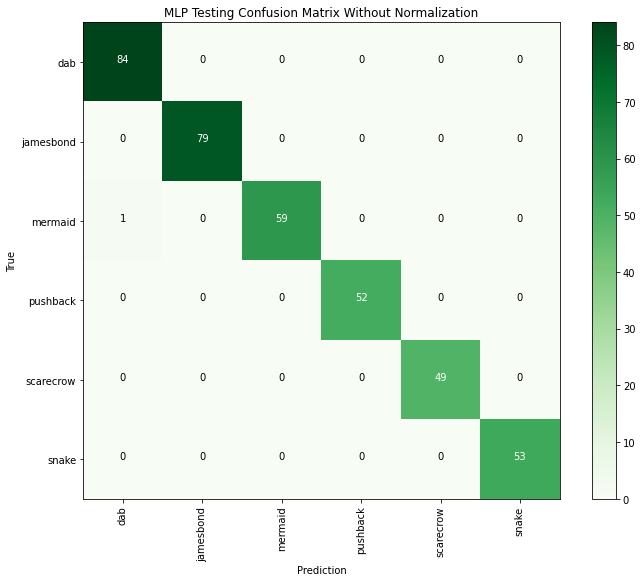

Confusion Matrix With Normalization


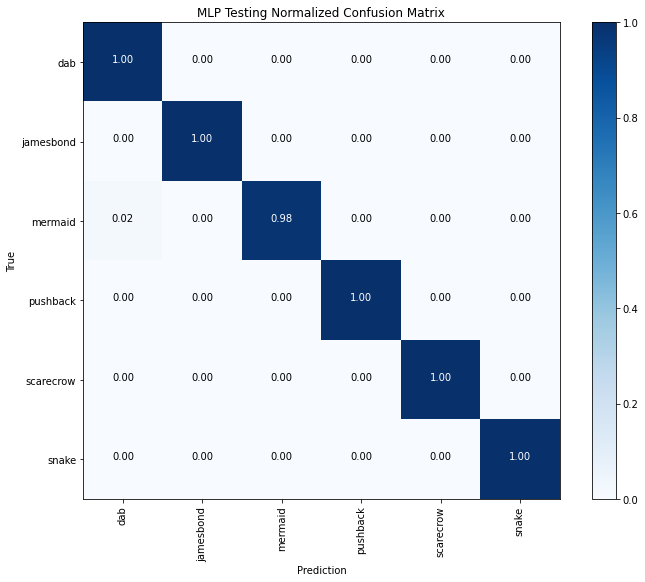

In [28]:
cnf_matrix = matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=activities, title='MLP Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='MLP Testing Normalized Confusion Matrix')

plt.show()


In [29]:
for layerNum, layer in enumerate(model1.layers):
 #   print(layerNum)
    weights = layer.get_weights()[0]
    biases = layer.get_weights()[1]
    
    for toNeuronNum, bias in enumerate(biases):
        print(f'{layerNum}B -> L{layerNum+1}N{toNeuronNum}: {bias}')
        
    for fromNeuronNum, wgt in enumerate(weights):
        for toNeuronNum, wgt2 in enumerate(wgt):
            print(f'L{layerNum}N{fromNeuronNum} -> L{layerNum+1}N{toNeuronNum} = {wgt2}')

0B -> L1N0: 0.0426061749458313
0B -> L1N1: -0.05526681989431381
0B -> L1N2: -0.0259782113134861
0B -> L1N3: -0.07368122786283493
0B -> L1N4: -0.016460144892334938
0B -> L1N5: 0.10667722672224045
0B -> L1N6: 0.14719386398792267
0B -> L1N7: -0.12021829932928085
0B -> L1N8: -0.12381713092327118
0B -> L1N9: 0.026477042585611343
0B -> L1N10: -0.11891531944274902
0B -> L1N11: 0.06525836139917374
0B -> L1N12: -0.19664344191551208
0B -> L1N13: -0.029490936547517776
0B -> L1N14: -0.011160427704453468
0B -> L1N15: -0.10001838207244873
0B -> L1N16: 0.008128693327307701
0B -> L1N17: 0.01284466776996851
0B -> L1N18: -0.08228780329227448
0B -> L1N19: 0.08556041121482849
0B -> L1N20: 0.17402547597885132
0B -> L1N21: 0.08292707055807114
0B -> L1N22: 0.05901068449020386
0B -> L1N23: -0.09474670886993408
0B -> L1N24: -0.05988915637135506
0B -> L1N25: -0.00991731882095337
0B -> L1N26: 0.07992137968540192
0B -> L1N27: -0.0037166900001466274
0B -> L1N28: -0.04452620819211006
0B -> L1N29: 0.0591727681457996

L0N12 -> L1N125 = 0.02599118836224079
L0N12 -> L1N126 = 0.10354815423488617
L0N12 -> L1N127 = 0.10196293890476227
L0N12 -> L1N128 = -0.11465722322463989
L0N12 -> L1N129 = 0.11470963805913925
L0N12 -> L1N130 = -0.049187399446964264
L0N12 -> L1N131 = 0.059864405542612076
L0N12 -> L1N132 = -0.09024450927972794
L0N12 -> L1N133 = 0.033968351781368256
L0N12 -> L1N134 = -0.11610650271177292
L0N12 -> L1N135 = 0.106905996799469
L0N12 -> L1N136 = 0.09453494846820831
L0N12 -> L1N137 = -0.09908293187618256
L0N12 -> L1N138 = -0.05559367313981056
L0N12 -> L1N139 = 0.04718511179089546
L0N12 -> L1N140 = 0.09440755844116211
L0N12 -> L1N141 = 0.09000907838344574
L0N12 -> L1N142 = 0.04620157182216644
L0N12 -> L1N143 = 0.05621306970715523
L0N12 -> L1N144 = 0.0953962579369545
L0N12 -> L1N145 = -0.09103745967149734
L0N12 -> L1N146 = 0.007813571952283382
L0N12 -> L1N147 = -0.04979044944047928
L0N12 -> L1N148 = 0.007612014655023813
L0N12 -> L1N149 = -0.05787750706076622
L0N12 -> L1N150 = -0.04536369442939758


L0N26 -> L1N40 = 0.015627175569534302
L0N26 -> L1N41 = 0.09858100116252899
L0N26 -> L1N42 = 0.10486955940723419
L0N26 -> L1N43 = -0.16844497621059418
L0N26 -> L1N44 = -0.2739189863204956
L0N26 -> L1N45 = -0.04197649657726288
L0N26 -> L1N46 = -0.10411040484905243
L0N26 -> L1N47 = -0.04584161937236786
L0N26 -> L1N48 = -0.08838275074958801
L0N26 -> L1N49 = -0.1813068389892578
L0N26 -> L1N50 = 0.32697078585624695
L0N26 -> L1N51 = 0.028605690225958824
L0N26 -> L1N52 = 0.08294907212257385
L0N26 -> L1N53 = -0.1375027745962143
L0N26 -> L1N54 = 0.04437386244535446
L0N26 -> L1N55 = -0.014110608026385307
L0N26 -> L1N56 = 0.04566166549921036
L0N26 -> L1N57 = 0.4624771475791931
L0N26 -> L1N58 = 0.07848197966814041
L0N26 -> L1N59 = 0.0801011174917221
L0N26 -> L1N60 = -0.22205577790737152
L0N26 -> L1N61 = 0.11159469187259674
L0N26 -> L1N62 = -0.16522535681724548
L0N26 -> L1N63 = -0.07662173360586166
L0N26 -> L1N64 = 0.1290743201971054
L0N26 -> L1N65 = 0.1268375664949417
L0N26 -> L1N66 = 0.12266492843

L0N39 -> L1N212 = -0.11439097672700882
L0N39 -> L1N213 = -0.001859199022874236
L0N39 -> L1N214 = -0.021460266783833504
L0N39 -> L1N215 = 0.08717723190784454
L0N39 -> L1N216 = -0.061296116560697556
L0N39 -> L1N217 = -0.06036848947405815
L0N39 -> L1N218 = 0.06958761811256409
L0N39 -> L1N219 = 0.07251524925231934
L0N39 -> L1N220 = 0.02671263925731182
L0N39 -> L1N221 = 0.008881586603820324
L0N39 -> L1N222 = -0.07550652325153351
L0N39 -> L1N223 = -0.04698367789387703
L0N39 -> L1N224 = 0.15227974951267242
L0N39 -> L1N225 = -0.13096749782562256
L0N39 -> L1N226 = -0.026470152661204338
L0N39 -> L1N227 = -0.0442962646484375
L0N39 -> L1N228 = 0.11801160126924515
L0N39 -> L1N229 = 0.07516233623027802
L0N39 -> L1N230 = 0.05772686377167702
L0N39 -> L1N231 = -0.0888092890381813
L0N39 -> L1N232 = -0.030504897236824036
L0N39 -> L1N233 = 0.20509463548660278
L0N39 -> L1N234 = 0.07355983555316925
L0N39 -> L1N235 = -0.04552668333053589
L0N39 -> L1N236 = -0.00214600283652544
L0N39 -> L1N237 = 0.073872193694

L0N53 -> L1N243 = -0.02505505084991455
L0N53 -> L1N244 = 0.10031652450561523
L0N53 -> L1N245 = -0.12265230715274811
L0N53 -> L1N246 = -0.030927550047636032
L0N53 -> L1N247 = 0.06912841647863388
L0N53 -> L1N248 = 0.08844920247793198
L0N53 -> L1N249 = 0.009726926684379578
L0N53 -> L1N250 = -0.03392120078206062
L0N53 -> L1N251 = -0.03220956772565842
L0N53 -> L1N252 = -0.104185551404953
L0N53 -> L1N253 = -0.0035720737650990486
L0N53 -> L1N254 = -0.049138929694890976
L0N53 -> L1N255 = -0.004378990735858679
L0N54 -> L1N0 = -0.03030211664736271
L0N54 -> L1N1 = -0.02236294001340866
L0N54 -> L1N2 = -0.1400739997625351
L0N54 -> L1N3 = -0.010537704452872276
L0N54 -> L1N4 = 0.1277698278427124
L0N54 -> L1N5 = 0.13584493100643158
L0N54 -> L1N6 = -0.05880293250083923
L0N54 -> L1N7 = -0.06326289474964142
L0N54 -> L1N8 = 0.07211686670780182
L0N54 -> L1N9 = -0.004727335646748543
L0N54 -> L1N10 = -0.06688809394836426
L0N54 -> L1N11 = -0.1037573516368866
L0N54 -> L1N12 = 0.11566577106714249
L0N54 -> L1N13

L0N69 -> L1N31 = -0.10410033911466599
L0N69 -> L1N32 = 0.11553335189819336
L0N69 -> L1N33 = -0.11143875122070312
L0N69 -> L1N34 = -0.08423478156328201
L0N69 -> L1N35 = -0.061062827706336975
L0N69 -> L1N36 = 0.05137357860803604
L0N69 -> L1N37 = -0.04340110346674919
L0N69 -> L1N38 = 0.051883842796087265
L0N69 -> L1N39 = 0.13219836354255676
L0N69 -> L1N40 = -0.03845583647489548
L0N69 -> L1N41 = -0.13676971197128296
L0N69 -> L1N42 = -0.1020287349820137
L0N69 -> L1N43 = -0.08289255201816559
L0N69 -> L1N44 = 0.051025714725255966
L0N69 -> L1N45 = -0.06928271055221558
L0N69 -> L1N46 = -0.0052381278946995735
L0N69 -> L1N47 = -0.07595782727003098
L0N69 -> L1N48 = 0.12851634621620178
L0N69 -> L1N49 = 0.015623961575329304
L0N69 -> L1N50 = 0.08692808449268341
L0N69 -> L1N51 = 0.10001109540462494
L0N69 -> L1N52 = 0.03837078437209129
L0N69 -> L1N53 = 0.10196613520383835
L0N69 -> L1N54 = -0.059199556708335876
L0N69 -> L1N55 = -0.036235708743333817
L0N69 -> L1N56 = 0.023940062150359154
L0N69 -> L1N57 =

L1N24 -> L2N62 = -0.017559103667736053
L1N24 -> L2N63 = 0.021239809691905975
L1N24 -> L2N64 = -0.1715393364429474
L1N24 -> L2N65 = 0.03909480199217796
L1N24 -> L2N66 = -0.04735705628991127
L1N24 -> L2N67 = -0.07508857548236847
L1N24 -> L2N68 = 0.04577567055821419
L1N24 -> L2N69 = -0.07602671533823013
L1N24 -> L2N70 = 0.15237298607826233
L1N24 -> L2N71 = -0.03107967972755432
L1N24 -> L2N72 = -0.07876984775066376
L1N24 -> L2N73 = 0.21362823247909546
L1N24 -> L2N74 = 0.07995016872882843
L1N24 -> L2N75 = -0.1043536439538002
L1N24 -> L2N76 = 0.12177146226167679
L1N24 -> L2N77 = 0.1335171014070511
L1N24 -> L2N78 = 0.1051553413271904
L1N24 -> L2N79 = -0.07783418148756027
L1N24 -> L2N80 = 0.056033696979284286
L1N24 -> L2N81 = 0.04856012389063835
L1N24 -> L2N82 = 0.03653384745121002
L1N24 -> L2N83 = 0.012111127376556396
L1N24 -> L2N84 = -0.04598185792565346
L1N24 -> L2N85 = -0.15705740451812744
L1N24 -> L2N86 = 0.04198822006583214
L1N24 -> L2N87 = -0.07788747549057007
L1N24 -> L2N88 = -0.257213

L1N55 -> L2N94 = 0.04918625205755234
L1N55 -> L2N95 = 0.07531753927469254
L1N55 -> L2N96 = -0.018010711297392845
L1N55 -> L2N97 = 0.05564427375793457
L1N55 -> L2N98 = 0.005973300896584988
L1N55 -> L2N99 = -0.027582485228776932
L1N55 -> L2N100 = 0.002452115062624216
L1N55 -> L2N101 = 0.07518648356199265
L1N55 -> L2N102 = 0.1866302341222763
L1N55 -> L2N103 = -0.015479926951229572
L1N55 -> L2N104 = 0.1341116726398468
L1N55 -> L2N105 = -0.009724634699523449
L1N55 -> L2N106 = -0.03395700454711914
L1N55 -> L2N107 = 0.026404405012726784
L1N55 -> L2N108 = 0.055956415832042694
L1N55 -> L2N109 = 0.0025927023962140083
L1N55 -> L2N110 = -0.17053113877773285
L1N55 -> L2N111 = 0.11042340099811554
L1N55 -> L2N112 = -0.003337736940011382
L1N55 -> L2N113 = -0.1711810678243637
L1N55 -> L2N114 = -0.0919344574213028
L1N55 -> L2N115 = 0.04513608664274216
L1N55 -> L2N116 = 0.12400740385055542
L1N55 -> L2N117 = -0.12672927975654602
L1N55 -> L2N118 = 0.15610972046852112
L1N55 -> L2N119 = 0.025194304063916206


L1N86 -> L2N125 = 0.045538246631622314
L1N86 -> L2N126 = 0.058140721172094345
L1N86 -> L2N127 = -0.13260897994041443
L1N87 -> L2N0 = -0.05362442508339882
L1N87 -> L2N1 = 0.04471690207719803
L1N87 -> L2N2 = 0.02586708404123783
L1N87 -> L2N3 = 0.030090386047959328
L1N87 -> L2N4 = -0.10352589190006256
L1N87 -> L2N5 = 0.10058049857616425
L1N87 -> L2N6 = 0.0698133260011673
L1N87 -> L2N7 = 0.12396525591611862
L1N87 -> L2N8 = 0.00494337547570467
L1N87 -> L2N9 = -0.09019148349761963
L1N87 -> L2N10 = 0.03467225283384323
L1N87 -> L2N11 = 0.10089362412691116
L1N87 -> L2N12 = 0.05340456962585449
L1N87 -> L2N13 = -0.026881571859121323
L1N87 -> L2N14 = 0.16400757431983948
L1N87 -> L2N15 = 0.09636719524860382
L1N87 -> L2N16 = -0.1131574809551239
L1N87 -> L2N17 = 0.14611317217350006
L1N87 -> L2N18 = 0.044196199625730515
L1N87 -> L2N19 = -0.07980330288410187
L1N87 -> L2N20 = -0.06517776846885681
L1N87 -> L2N21 = 0.05636902526021004
L1N87 -> L2N22 = 0.10630777478218079
L1N87 -> L2N23 = 0.085095539689064

L1N118 -> L2N29 = 0.11289117485284805
L1N118 -> L2N30 = -0.032156262546777725
L1N118 -> L2N31 = 0.10163847357034683
L1N118 -> L2N32 = -0.1954837441444397
L1N118 -> L2N33 = 0.0534929521381855
L1N118 -> L2N34 = 0.019877959042787552
L1N118 -> L2N35 = 0.036900825798511505
L1N118 -> L2N36 = 0.08321863412857056
L1N118 -> L2N37 = -0.014798141084611416
L1N118 -> L2N38 = 0.11111348867416382
L1N118 -> L2N39 = -0.011797267012298107
L1N118 -> L2N40 = -0.004597729071974754
L1N118 -> L2N41 = -0.12544572353363037
L1N118 -> L2N42 = 0.05856553465127945
L1N118 -> L2N43 = 0.13869814574718475
L1N118 -> L2N44 = 0.05987856909632683
L1N118 -> L2N45 = 0.06623860448598862
L1N118 -> L2N46 = 0.0013764292234554887
L1N118 -> L2N47 = 0.15455466508865356
L1N118 -> L2N48 = 0.01385184470564127
L1N118 -> L2N49 = 0.029050618410110474
L1N118 -> L2N50 = -0.14431487023830414
L1N118 -> L2N51 = -0.043612994253635406
L1N118 -> L2N52 = -0.04823894426226616
L1N118 -> L2N53 = 0.044558051973581314
L1N118 -> L2N54 = -0.08083997666

L1N146 -> L2N112 = 0.028982514515519142
L1N146 -> L2N113 = -0.04315422475337982
L1N146 -> L2N114 = -0.06482285261154175
L1N146 -> L2N115 = -0.0050974199548363686
L1N146 -> L2N116 = -0.034855395555496216
L1N146 -> L2N117 = -0.08960497379302979
L1N146 -> L2N118 = -0.03120114468038082
L1N146 -> L2N119 = -0.002913581905886531
L1N146 -> L2N120 = -0.051747195422649384
L1N146 -> L2N121 = -0.037856556475162506
L1N146 -> L2N122 = 0.04660536348819733
L1N146 -> L2N123 = 0.037241533398628235
L1N146 -> L2N124 = 0.0788796991109848
L1N146 -> L2N125 = -0.10873030871152878
L1N146 -> L2N126 = -0.0929313376545906
L1N146 -> L2N127 = 0.024844041094183922
L1N147 -> L2N0 = -0.0715075358748436
L1N147 -> L2N1 = -0.0429389663040638
L1N147 -> L2N2 = 0.08610361814498901
L1N147 -> L2N3 = -0.049672938883304596
L1N147 -> L2N4 = 0.06407035887241364
L1N147 -> L2N5 = -0.004157076124101877
L1N147 -> L2N6 = 0.12766435742378235
L1N147 -> L2N7 = 0.0119503578171134
L1N147 -> L2N8 = 0.006919184233993292
L1N147 -> L2N9 = -0.1

L1N176 -> L2N104 = 0.0355227030813694
L1N176 -> L2N105 = -0.02490278147161007
L1N176 -> L2N106 = -0.10497438162565231
L1N176 -> L2N107 = -0.03344672545790672
L1N176 -> L2N108 = 0.11415931582450867
L1N176 -> L2N109 = -0.0945952907204628
L1N176 -> L2N110 = -0.04504162073135376
L1N176 -> L2N111 = -0.07756703346967697
L1N176 -> L2N112 = 0.05671162158250809
L1N176 -> L2N113 = -0.07329624146223068
L1N176 -> L2N114 = -0.047054920345544815
L1N176 -> L2N115 = 0.0792931467294693
L1N176 -> L2N116 = 0.19617575407028198
L1N176 -> L2N117 = 0.09645741432905197
L1N176 -> L2N118 = -0.08058825135231018
L1N176 -> L2N119 = 0.06275983899831772
L1N176 -> L2N120 = 0.00032912063761614263
L1N176 -> L2N121 = 0.12488768994808197
L1N176 -> L2N122 = -0.01121398713439703
L1N176 -> L2N123 = -0.05279487743973732
L1N176 -> L2N124 = 0.14624567329883575
L1N176 -> L2N125 = -0.05257522314786911
L1N176 -> L2N126 = 0.06022453308105469
L1N176 -> L2N127 = 0.17072217166423798
L1N177 -> L2N0 = -0.006567368283867836
L1N177 -> L2

L1N208 -> L2N7 = 0.004182212986052036
L1N208 -> L2N8 = 0.09130853414535522
L1N208 -> L2N9 = 0.015333699993789196
L1N208 -> L2N10 = 0.0635083019733429
L1N208 -> L2N11 = 0.112235888838768
L1N208 -> L2N12 = 0.09698255360126495
L1N208 -> L2N13 = -0.05363424867391586
L1N208 -> L2N14 = -0.023612510412931442
L1N208 -> L2N15 = -0.02508508786559105
L1N208 -> L2N16 = 0.14046885073184967
L1N208 -> L2N17 = -0.06310859322547913
L1N208 -> L2N18 = -0.0627000629901886
L1N208 -> L2N19 = -0.011764422990381718
L1N208 -> L2N20 = -0.046998072415590286
L1N208 -> L2N21 = 0.044085487723350525
L1N208 -> L2N22 = -0.07645373046398163
L1N208 -> L2N23 = -0.021534746512770653
L1N208 -> L2N24 = 0.007857197895646095
L1N208 -> L2N25 = -0.004391693975776434
L1N208 -> L2N26 = -0.11751101166009903
L1N208 -> L2N27 = -0.013193648308515549
L1N208 -> L2N28 = 0.06215975806117058
L1N208 -> L2N29 = -0.038521457463502884
L1N208 -> L2N30 = 0.03182011470198631
L1N208 -> L2N31 = 0.08752743899822235
L1N208 -> L2N32 = 0.0752404853701

L1N239 -> L2N39 = -0.033058661967515945
L1N239 -> L2N40 = -0.11723154783248901
L1N239 -> L2N41 = -0.053647153079509735
L1N239 -> L2N42 = -0.08587023615837097
L1N239 -> L2N43 = -0.08994036167860031
L1N239 -> L2N44 = 0.06799392402172089
L1N239 -> L2N45 = -0.11035314947366714
L1N239 -> L2N46 = 0.18968862295150757
L1N239 -> L2N47 = 0.12851320207118988
L1N239 -> L2N48 = -0.07823245972394943
L1N239 -> L2N49 = 0.144451305270195
L1N239 -> L2N50 = -0.062307439744472504
L1N239 -> L2N51 = -0.10743381828069687
L1N239 -> L2N52 = 0.09998126327991486
L1N239 -> L2N53 = 0.05867194011807442
L1N239 -> L2N54 = 0.015275687910616398
L1N239 -> L2N55 = 0.04894541949033737
L1N239 -> L2N56 = -0.09122869372367859
L1N239 -> L2N57 = 0.04516439512372017
L1N239 -> L2N58 = -0.071771040558815
L1N239 -> L2N59 = -0.03634245693683624
L1N239 -> L2N60 = -0.18221049010753632
L1N239 -> L2N61 = 0.1997905969619751
L1N239 -> L2N62 = 0.18246440589427948
L1N239 -> L2N63 = 0.047815702855587006
L1N239 -> L2N64 = -0.0450788624584674

In [30]:
# # #With minmax
# # # Dense: Fully connected layer and the most common type of layer used on multi-layer perceptron models.
# # # Dropout: Apply dropout to the model, setting a fraction of inputs to zero in an effort to reduce over fitting.
# # # Merge: Combine the inputs from multiple models into a single model.
# # model = Sequential()
# # bias_initializer = HeNormal()

# # First hidden layer
# model.add(Dense(256, input_shape = (81,), activation = 'relu', use_bias=True, bias_initializer=bias_initializer))

# # Randomly drop 30% of this layer for training
# #model.add(Dropout(0.3))

# model.add(Dense(128, activation = 'relu', use_bias=True, bias_initializer=bias_initializer))
# #model.add(Dropout(0.3))

# # Finally our output with softmax activation
# model.add(Dense(8, activation = 'softmax'))

# # Create a Stochastic Gradient Descent optimizer with a learn rate of 0.01
# # and a decay of 1e-6, which is the amount that the learn rate is decayed
# # by periodically. Finally there's a momentum of 0.9 which helps control
# # "overshoot"
# sgd  = SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9)

# # Now compile the model. We use a "categorical cross entropy" loss function
# # which is more sophisticated than the simple mean-squared loss function
# model.compile(loss = 'categorical_crossentropy', optimizer = sgd,
#             metrics = 'accuracy')

In [31]:
# from sklearn.preprocessing import MinMaxScaler
# X_train = X_train.reshape(X_train.shape[0], 81)
# X_test = X_test.reshape(X_test.shape[0], 81)
# # X_valid = X_valid.reshape(X_valid.shape[0], 81)

# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# # X_valid = X_valid.astype('float32')

# # Change to float32 and scale to 0 to 1
# scaler = MinMaxScaler(feature_range = (0, 1))
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)
# # X_valid = scaler.fit_transform(X_valid)
# print(X_train)

In [32]:
X_train.shape

(763, 72)

In [33]:
print(y_train)
print(y_train.shape)

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
(763, 6)


In [34]:
# model.fit(x = X_train, y = y_train, shuffle = True, batch_size = 60, 
#           epochs = 500, validation_data = (X_test, y_test))

In [35]:
# loss, acc = model.evaluate(x = X_test, y = y_test)
# print("Final loss is %3.2f, accuracy is %3.2f." % (loss, acc))

In [36]:
# # Merge inputs and targets
# inputs = np.concatenate((X_train, X_test), axis=0)
# targets = np.concatenate((y_train, y_test), axis=0)

# # Define the K-fold Cross Validator
# kfold = KFold(n_splits=10, shuffle=True)

# # K-fold Cross Validation model evaluation
# fold_no = 1
# for train, test in kfold.split(inputs, targets):

#     # Generate a print
#     print('------------------------------------------------------------------------')
#     print(f'Training for fold {fold_no} ...')

#     # Fit data to model
#     history = model1.fit(inputs[train], targets[train],
#               batch_size=60,
#               epochs=10)

#     # Generate generalization metrics
#     scores = model1.evaluate(inputs[test], targets[test], verbose=0)
#     print(f'Score for fold {fold_no}: {model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%')
#     acc_per_fold = []
#     loss_per_fold = []
#     acc_per_fold.append(scores[1]*100)
#     loss_per_fold.append(scores[0])

#     # Increase fold number
#     fold_no = fold_no + 1

In [37]:
# predictions = model.predict(x = X_test)
# predictions

In [38]:
# matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

In [39]:
# cnf_matrix = matrix
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure(figsize=(10,8))
# plot_confusion_matrix(cnf_matrix, classes=activities, title='MLP Testing Confusion Matrix Without Normalization')

# # Plot normalized confusion matrix
# plt.figure(figsize=(10,8))
# plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='MLP Testing Normalized Confusion Matrix')

# plt.show()


In [40]:
# for layerNum, layer in enumerate(model.layers):
#  #   print(layerNum)
#     weights = layer.get_weights()[0]
#     biases = layer.get_weights()[1]
    
#     for toNeuronNum, bias in enumerate(biases):
#         print(f'{layerNum}B -> L{layerNum+1}N{toNeuronNum}: {bias}')
        
#     for fromNeuronNum, wgt in enumerate(weights):
#         for toNeuronNum, wgt2 in enumerate(wgt):
#             print(f'L{layerNum}N{fromNeuronNum} -> L{layerNum+1}N{toNeuronNum} = {wgt2}')

In [41]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

# class MLP(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
#         super(MLP, self).__init__()
#         self.layer1 = nn.Linear(input_size, hidden_size1, bias = True)
#         self.layer2 = nn.Linear(hidden_size1, hidden_size2, bias = True)
#         self.layer3 = nn.Linear(hidden_size2, output_size, bias = True)
    
#     def forward(self,x):
        
#         y = self.layer1(x)
#         y_output = F.sigmoid(y)
#         z = self.layer2(y_output)
#         z_output = F.sigmoid(z)
        
#         label = self.layer3(z_output)
#         label_output = F.softmax(label)
        
#         return label_output
    


In [42]:
# from keras.utils.np_utils import to_categorical

# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# # X_valid = X_valid.astype('float32')

# #y_train.shape
# # y_train = to_categorical(y_train, 8)
# # y_test = to_categorical(y_test, 8)
# # y_valid = to_categorical(y_valid, 10)
# y_train

In [43]:
# model = MLP(81, 256, 128, 8)   
# print(model)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

In [44]:
# def get_error(scores,labels):
#     predicted_labels = scores.argmax(dim = 1)
#     indicator = (predicted_labels == labels)
#     num_matches = indicator.sum()
    
#     return 1-num_matches.float()

In [45]:
# for epoch in range(20):
    
#     running_loss = 0
#     running_error = 0
#     num_labels = 0

#     shuffled_indices = torch.randperm(174)
# #     
#     X = torch.from_numpy(X_train)
    
#     y = torch.from_numpy(y_train)
# #     print(X.type)
#     for count in range (0,174):
#         optimizer.zero_grad()
#         minbatch_data = X[count].view(1,81)
#         minbatch_label = y[count].view(1)
        
#         minbatch_data.requires_grad_()
#         scores = model(minbatch_data)
        
#         log_prob = torch.log(scores)
#         loss = criterion(log_prob, minbatch_label)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.detach().item()
        
#         error = get_error(scores.detach(), minbatch_label)
#         running_error += error.item()
        
#         num_labels += 1
        
#     total_loss = running_loss/num_labels
#     total_error = running_error/num_labels
# #         minbatch_label = y_train[2]
# #         minbatch_data=torch.tensor(minbatch_data)
# #         print(minbatch_label)
# #         minbatch_label=torch.tensor(minbatch_label)
#         #minbatch_label=torch.Tensor([1])*minbatch_label
#        # minbatch_label=torch.from_numpy(minbatch_label)

# #         print(minbatch_label)
# # #         minbatch_label=minbatch_label.view(-1)
# #         minbatch_data.requires_grad_()
        
# #         scores = model(minbatch_data)
# #         print(scores)
# #         label=torch.tensor([2])
# #         loss = criterion(scores, label)
# #         loss.backward()
# #         optimizer.step()
        